In [84]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [85]:
import plotly.express as px
import plotly as pl

In [86]:
data = pd.read_csv('../Data/properatti.csv')

In [87]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121220 entries, 0 to 121219
Data columns (total 26 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Unnamed: 0                  121220 non-null  int64  
 1   operation                   121220 non-null  object 
 2   property_type               121220 non-null  object 
 3   place_name                  121197 non-null  object 
 4   place_with_parent_names     121220 non-null  object 
 5   country_name                121220 non-null  object 
 6   state_name                  121220 non-null  object 
 7   geonames_id                 102503 non-null  float64
 8   lat-lon                     69670 non-null   object 
 9   lat                         69670 non-null   float64
 10  lon                         69670 non-null   float64
 11  price                       100810 non-null  float64
 12  currency                    100809 non-null  object 
 13  price_aprox_lo

<a id="indice"></a>
# Indice
1. [Ambientes (Rooms)](#ambientes)
2. [Extracciones datos](#Extracciones)
3. [Barrios cerrados](#barrios)

<a id="ambiente"></a>
## 1. Ambientes (Rooms)
[volver al indice](#indice)

[Etapa 1: Revisión exploratoria de campo Room](#ambientes1)\
1.1 Faltantes en rooms\
1.2 Distribución Rooms abierto por property_types\
1.3 Relación Rooms con price\
1.4 Relación Rooms con superficie


\
[Etapa 2: Extracciones de Room desde description](#ambientes2)\
2.1 Extracción desde 'description': Dígito + amb, Número en text + amb, Monoambiente\
2.2 Agregar al dataset nuevas variables extraidas\
2.3 Nueva variable room_expanded a partir de Rooms y las nuevas variables\
2.4 Revisión nuevas distribuciones


\
[Etapa 3: Inclusión de variable dormitorios](#ambientes3) \
3.1 Extracción Dorm de description\
3.2 Relación dorm con ambientes\
3.3 Agregar al data set\
3.4 Revisión nuevas distribuciones


[Etapa 4: Revisión de inconsistencias](#ambientes4)\
4.1 Propiedades con dormitorios >= a ambientes\
4.2 Propiedades con ambientes extraidos de descripción > ambientes\
4.3 Casas de 1 ambiente

[Etapa 5: Distribuciones Finales](#ambientes5)\


#### Resultado: Variables agregadas
 26  mono_desc                   7344 non-null    float64
 27  amb_text_desc               5106 non-null    float64
 28  amb_num_desc                36241 non-null   float64
 29  room_expanded               71664 non-null   float64
 30  dorm                        37263 non-null   float64
 31  room_expanded_2             78284 non-null   float64
 32  room_cat                    78039 non-null   object 
 33  room_fixed                  78039 non-null   float64


<a id="ambientes1"></a>

### Etapa 1: Revisión exploratoria campo Rooms


<a id='sin_room'></a>
1.1 Faltantes en campo Rooms

In [88]:
#mascara Rooms incompleto
mask_no_rooms = data['rooms'].isnull()
#mascara Rooms
mask_rooms = data['rooms'].notnull()

In [89]:
#Calcular cuantos regitros no tiene room
print('Cantidad de nulos en Rooms: '+str(mask_no_rooms.sum()))
print('% de nulos en Rooms: '+str(mask_no_rooms.sum()/mask_no_rooms.shape[0]*100))

Cantidad de nulos en Rooms: 73830
% de nulos en Rooms: 60.90579112357697


<a id='rooms_property_type'></a>
1.2 Distribución Rooms por property_types


Distribución de rooms por property type


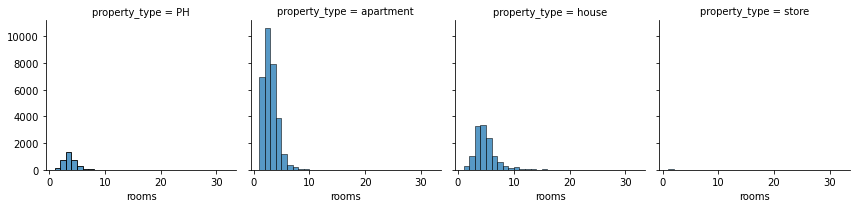

In [90]:
#1.2 Distribución de Rooms. 
#Histograma de Rooms por property_type
print('Distribución de rooms por property type')
g = sns.FacetGrid(data, col='property_type')
g.map(sns.histplot, "rooms", binwidth=1);


In [91]:
#Describe de rooms por property type
data.groupby('property_type').describe()[['rooms']]

rooms                                              
                 count      mean       std  min  25%  50%  75%   max
property_type                                                       
PH              3247.0  3.217431  1.239185  1.0  2.0  3.0  4.0  20.0
apartment      31268.0  2.508667  1.349485  1.0  2.0  2.0  3.0  32.0
house          12770.0  4.452388  2.295527  1.0  3.0  4.0  5.0  32.0
store            105.0  2.438095  2.214132  1.0  1.0  1.0  3.0  10.0

In [92]:
#Count de rooms por property_type
data.pivot_table(values='operation', aggfunc='count', columns='property_type', index='rooms').head(10)

#Es raro que haya houses de 1 ambiente

property_type      PH  apartment   house  store
rooms                                          
1.0             118.0     6940.0   264.0   55.0
2.0             744.0    10664.0  1008.0   17.0
3.0            1301.0     7946.0  3307.0   13.0
4.0             705.0     3867.0  3361.0    4.0
5.0             263.0     1162.0  2353.0    4.0
6.0              69.0      330.0  1002.0    2.0
7.0              24.0      174.0   566.0    6.0
8.0              10.0       86.0   312.0    1.0
9.0               5.0       34.0   145.0    NaN
10.0              4.0       22.0   197.0    3.0

1.3 Relación rooms con price

Relación rooms con Precio es USD


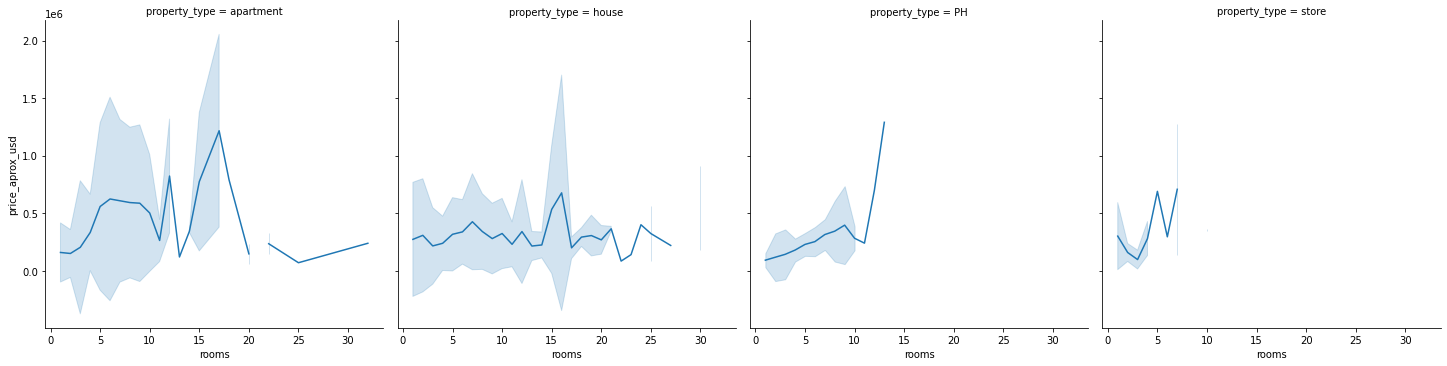

correlación :0.182916325996972


In [93]:
#Relación rooms con 'price_aprox_usd' con intervalo de confianza 95%
print('Relación rooms con Precio es USD')
sns.relplot(
    data=data,
    x="rooms", y="price_aprox_usd", col="property_type",col_order=['apartment','house','PH','store'],
    kind="line", ci='sd'
);
plt.show()
print('correlación :'+str(data['price_aprox_usd'].corr(data.rooms.astype(float))))


In [94]:
list_price_m2_fields=['price_aprox_usd','price_usd_per_m2','surface_covered_in_m2','surface_total_in_m2']

In [95]:
#Describe de data original
data[list_price_m2_fields].describe()

price_aprox_usd  price_usd_per_m2  surface_covered_in_m2  \
count     1.008100e+05      68617.000000          101313.000000   
mean      2.397006e+05       2160.086916             133.050181   
std       3.913239e+05       2759.288621             724.351479   
min       0.000000e+00          0.600000               0.000000   
25%       8.973388e+04       1218.181818              45.000000   
50%       1.450000e+05       1800.000000              75.000000   
75%       2.650000e+05       2486.411765             150.000000   
max       4.654544e+07     206333.333333          187000.000000   

       surface_total_in_m2  
count         81892.000000  
mean            233.795328  
std            1782.222147  
min               0.000000  
25%              50.000000  
50%              84.000000  
75%             200.000000  
max          200000.000000

El dataset contiene valores extremos por lo cual cada análisis de relaciones se hará con un filtro que excluya outliers

In [96]:
#Funcion para devolver una mascara sin outliers con el método +-1.5 rango intercuartil.
#Recibe una lista de campos para hacer las agrupaciones donde se buscan outliers, 1 campo donde buscar outliers, 1 dataset
def no_outliers (group_by_list, outlier_field, data_input):
    mask_not_null = data_input[group_by_list].notnull().apply(lambda x: x.all(), axis=1)
    q3= data_input[mask_not_null].groupby(group_by_list)[outlier_field].transform(lambda x:x.quantile(0.75))
    q1= data_input[mask_not_null].groupby(group_by_list)[outlier_field].transform(lambda x:x.quantile(0.25))
    prom= data_input[mask_not_null].groupby(group_by_list)[outlier_field].transform(lambda x:x.mean())

    iqr=q3-q1

    outlier_top = q3 + iqr*1.5
    outlier_bottom = q1 - iqr*1.5

    
    df_outliers = pd.DataFrame({outlier_field:data_input[outlier_field],'outlier_top':outlier_top,'outlier_bottom':outlier_bottom})
    not_outlier = df_outliers.apply(lambda x: False if (x[outlier_field]>x.outlier_top) | (x[outlier_field]<x.outlier_bottom )else True, axis=1)
    return not_outlier




In [97]:
#Data sin ouliers de price_usd_per_m2
mask_no_outliers_price = no_outliers(['property_type','state_name','rooms'],'price_usd_per_m2',data )

data_no_outliers_price=data.loc[mask_no_outliers_price]
data_no_outliers_price[list_price_m2_fields].describe()

price_aprox_usd  price_usd_per_m2  surface_covered_in_m2  \
count     9.905400e+04      66861.000000           99603.000000   
mean      2.301728e+05       1900.869297             133.753672   
std       3.451803e+05       1299.479777             730.237884   
min       0.000000e+00          1.184571               0.000000   
25%       8.900000e+04       1202.185792              46.000000   
50%       1.420000e+05       1780.000000              75.000000   
75%       2.590000e+05       2426.470588             150.000000   
max       2.500000e+07      80000.000000          187000.000000   

       surface_total_in_m2  
count         80136.000000  
mean            230.707922  
std            1488.323478  
min               0.000000  
25%              50.000000  
50%              85.000000  
75%             200.000000  
max          154438.000000

Relación rooms con precio en USD incluyendo outliers
registros: 45499
correlación :0.18501266964550506


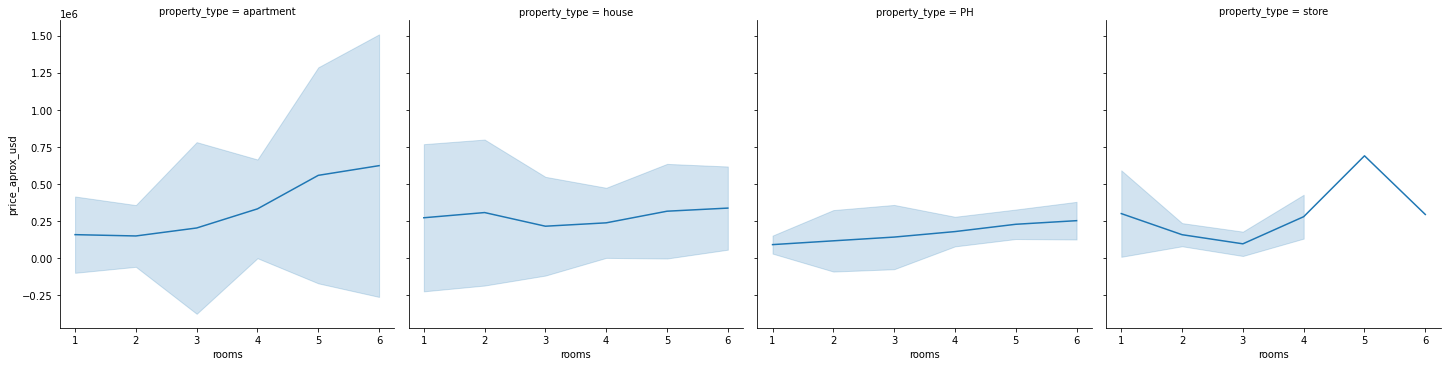

Relación rooms con precio en USD sin outliers
registros: 43760
correlación :0.3129766125743041


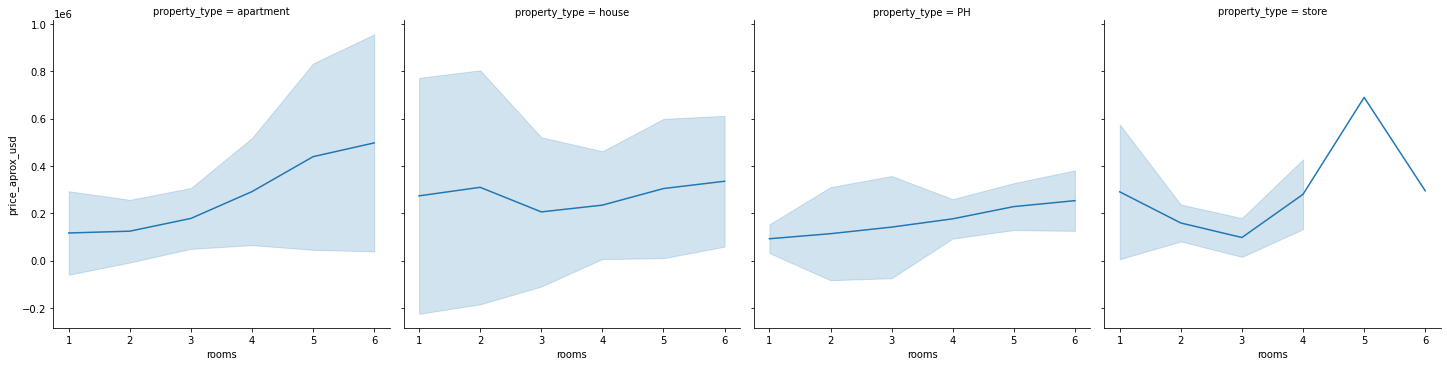

In [98]:
#Relación rooms con 'price_aprox_usd' con intervalo de confianza 95%. Con y sin outliers y solo hasta 6 rooms
data1_p = data_no_outliers_price.loc[data.rooms <7]

print('Relación rooms con precio en USD incluyendo outliers')
print('registros: '+str(data[data.rooms <7].shape[0]) )
print('correlación :'+str(data.loc[data.rooms <7]['price_aprox_usd'].corr(data.loc[data.rooms <7].rooms.astype(float))))

sns.relplot(
    data=data[data.rooms <7],
    x="rooms", y="price_aprox_usd", col="property_type",col_order=['apartment','house','PH','store'],
    kind="line", ci='sd'
);
plt.show()


print('Relación rooms con precio en USD sin outliers')
print('registros: '+str(data1_p.shape[0]) )
print('correlación :'+str(data1_p['price_aprox_usd'].corr(data1_p.rooms.astype(float))))
sns.relplot(
    data=data1_p,
    x="rooms", y="price_aprox_usd", col="property_type",col_order=['apartment','house','PH','store'],
    kind="line", ci='sd'
);

plt.show()

#Hay una distorsión con casas marcadas como 1 o 2 ambientes

1.4 Relación rooms con m2


In [99]:
#Sacar outliers del campo surface_covered_in_m2
mask_no_outliers_surf_cov = no_outliers(['property_type','state_name','rooms'],'surface_covered_in_m2',data )
no_outliers_surf_cov=data.loc[mask_no_outliers_surf_cov]

Relación rooms con superficie cubierta incluyendo outliers
registros: 45499
correlación :0.14484828796889376


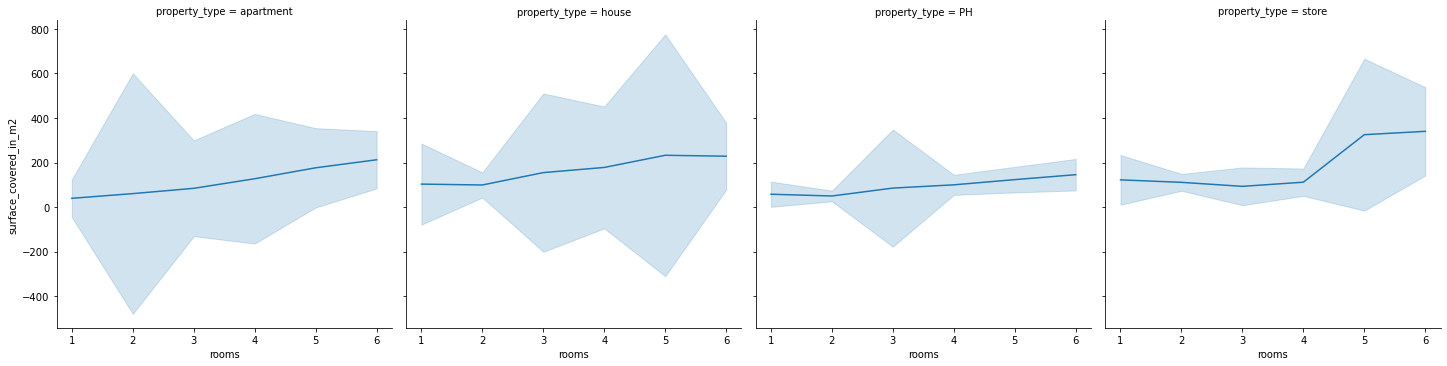

Relación rooms con superficie cubierta sin outliers
registros: 43447
correlación :0.6741922237301556


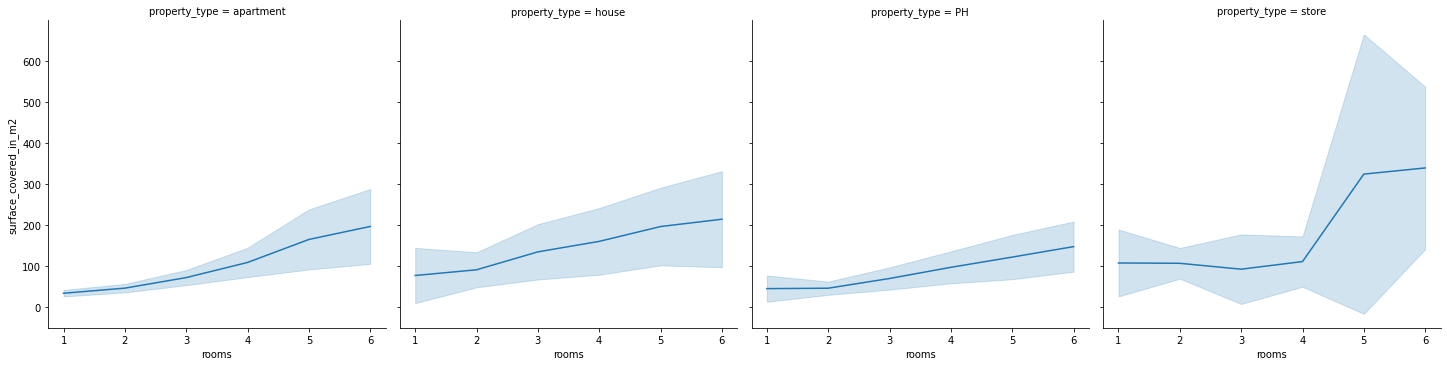

In [100]:
#Relación rooms con 'surface_covered_in_m2' con intervalo de confianza para cap fed. 1)Con outliers 2) Sin outliers. Hasta 6 rooms

print('Relación rooms con superficie cubierta incluyendo outliers')
print('registros: '+str(data[data.rooms <7].shape[0]) )
print('correlación :'+str(data.loc[data.rooms <7]['surface_covered_in_m2'].corr(data.loc[data.rooms <7].rooms.astype(float))))

sns.relplot(
    data=data.loc[data.rooms <7],
    x="rooms", y="surface_covered_in_m2", col="property_type",col_order=['apartment','house','PH','store'],
    kind="line", ci='sd'
)
plt.show()
data1_s = no_outliers_surf_cov.loc[no_outliers_surf_cov.rooms <7]
print('Relación rooms con superficie cubierta sin outliers')
print('registros: '+str(data1_s.shape[0]) )
print('correlación :'+str(data1_s['surface_covered_in_m2'].corr(data1_s.rooms.astype(float))))

sns.relplot(
    data=data1_s,
    x="rooms", y="surface_covered_in_m2", col="property_type",col_order=['apartment','house','PH','store'],
    kind="line", ci='sd'
);


<a id="ambientes2"></a>
### Etapa 2: Extracción de Rooms de description

In [101]:
#Funcion para buscar un patron y opcionalmente extraer información
def search_extract (pattern='', named_group=False, col=''):
    col=col.fillna('').astype(str)
    regex = re.compile(pattern, re.IGNORECASE)
    match = col.apply(lambda x: regex.search(x))
    mask = match.notnull()
    if named_group==False:
        return mask
    else:
        values_str = match[mask].apply(lambda x: x.group(named_group).lower())
        return values_str, mask

In [102]:
#Extraer Ambientes en 'description'
pattern_ambientes = '(?:^|\s+)(?P<amb>\d) Amb'

values_ambientes, mask_ambientes = search_extract(pattern_ambientes,'amb',data['description'])
values_ambientes=values_ambientes.astype(int)
mask_ambientes.sum(), values_ambientes.value_counts()

(36241,
 2    12535
 3    12009
 4     6640
 1     2408
 5     1827
 6      539
 7      222
 8       40
 9       21
 Name: description, dtype: int64)

Check consistencia: Distribución de Rooms para registros con 2 ambientes identificados en description


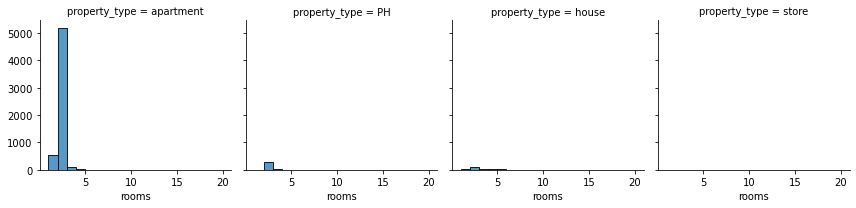

In [103]:
#Reviso si los valores que extraje tienen relación con lo que estaba antes en rooms
print('Check consistencia: Distribución de Rooms para registros con 2 ambientes identificados en description')
g = sns.FacetGrid(data.loc[(values_ambientes==2)&data.rooms.notnull()], col='property_type')
g.map(sns.histplot, "rooms", binwidth=1);

In [104]:
#correlacion ambientes extraidos con rooms orignal en casos que tenia
data.loc[mask_ambientes & data.rooms.notnull(),'rooms'].corr(values_ambientes.loc[data.rooms.notnull()].astype(float))

0.8353689403231707

In [105]:
#Extracción ambientes como strings
pattern_ambientes_str = '(?:^|\s+)(?P<amb>dos|tres|cuatro|cinco|seis|siete|ocho|nueve) Amb'
values_ambientes_str, mask_ambientes_str = search_extract(pattern_ambientes_str,'amb',data['description'])


In [106]:
#Pasar a lowercase y despues a numero
values_ambientes_str=values_ambientes_str.map(lambda x: x.lower())
values_ambientes_num = values_ambientes_str.map({'un':1,'dos': 2, 'tres':3 , 'cuatro':4, 'cinco':5, 'seis':6, 'siete':7, 'ocho':8,'nueve':9} )
mask_ambientes_str.sum(),values_ambientes_num.value_counts()

(5106,
 2    3204
 3    1489
 4     335
 5      56
 6      13
 7       8
 9       1
 Name: description, dtype: int64)

Check consistencia: Distribución de Rooms para registros con 4 ambientes identificados en description como texto


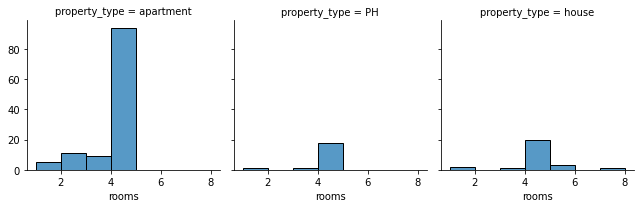

In [107]:
print('Check consistencia: Distribución de Rooms para registros con 4 ambientes identificados en description como texto')

g = sns.FacetGrid(data.loc[(values_ambientes_num==4)&data.rooms.notnull()], col='property_type')
g.map(sns.histplot, "rooms", binwidth=1);

In [108]:
#correlación
data.loc[mask_ambientes_str & data.rooms.notnull(),'rooms'].corr(values_ambientes_num.loc[data.rooms.notnull()])

0.5638385346409956

In [109]:
pattern_mono = '(?P<mono>Monoambiente)'
values_mono, mask_mono = search_extract(pattern_mono,'mono',data['description'])
mask_mono.shape, mask_mono.sum()

((121220,), 7344)

In [110]:
values_mono_num = values_mono.map(lambda x: 1).astype('int')
values_mono_num.value_counts()

1    7344
Name: description, dtype: int64

Check consistencia: Distribución de Rooms para registros identificado como Monoambiente en description


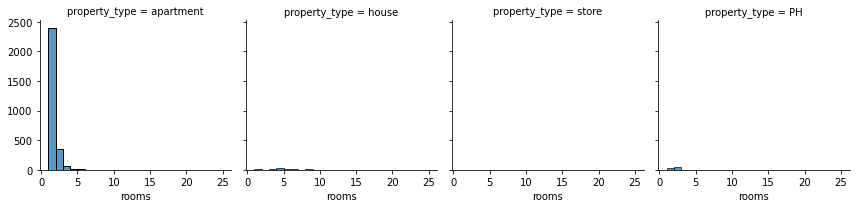

In [111]:
#Revisar que monoambientes tengan 1 rooms
print('Check consistencia: Distribución de Rooms para registros identificado como Monoambiente en description')

g = sns.FacetGrid(data.loc[mask_mono&data.rooms.notnull()], col='property_type')
g.map(sns.histplot, "rooms", binwidth=1);

In [112]:
#Buscar lofts
pattern_loft = '(?P<loft>Loft)'
values_loft, mask_loft = search_extract(pattern_loft,'loft',data['description'])
mask_loft.shape, mask_loft.sum()

((121220,), 1111)

Check consistencia: Distribución de Rooms para registros identificado como Loft en description


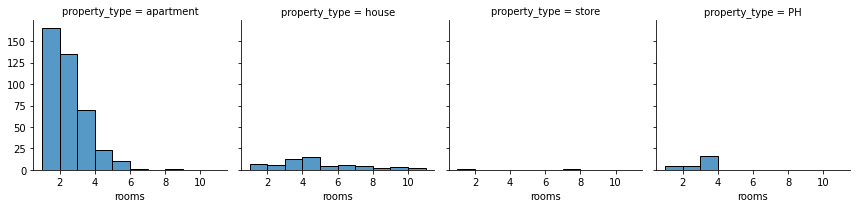

Descartado


In [113]:
#Graficar histograma
print('Check consistencia: Distribución de Rooms para registros identificado como Loft en description')

g = sns.FacetGrid(data.loc[mask_loft&data.rooms.notnull()], col='property_type')
g.map(sns.histplot, "rooms", binwidth=1);
#Se descarta porque hay demasiada dispersion entre lo que encuentro como loft y los ambientes reales
plt.show()
print('Descartado')

#### 2.2 Agregar al dataset nuevas variables Extraidas

In [114]:
print("nuevos valores: "+str((mask_no_rooms&(mask_ambientes|(mask_mono|mask_ambientes_str))).sum()))

nuevos valores: 24274


In [115]:
#Nueva serie con los ambientes de la descripcion
df_amb_desc=pd.concat({'mono_desc':values_mono_num,'amb_text_desc':values_ambientes_num,'amb_num_desc':values_ambientes},axis=1)

#Agregar los campos con extracciones al dataset por separado
data[['mono_desc','amb_text_desc','amb_num_desc']]=df_amb_desc
#Armo una nuevo columna copia de rooms en el dataframe


#### 2.3 Agregar al dataset nueva variable Room Expanded a partir de Rooms y nuevas variables extraidas

In [116]:
#Agregar al dataset la nueva columna room_expanded consolidando rooms con la nueva información
data['room_expanded']=data['rooms']

##### Ambiente desde número

In [117]:
#Agregar ambientes_from_desc a room_expanded
#Check que mascaras no rooms y ambientes tienen la misma longitud
mask_no_rooms.shape,mask_ambientes.shape

((121220,), (121220,))

In [118]:
#Agrego ambientes_from_desc a 'room_expanded' solo para los casos que no tenian completo room
#uso logical and porque tienen mismo shape
data.loc[np.logical_and(mask_no_rooms, mask_ambientes),'room_expanded'] = values_ambientes[mask_no_rooms]
data.room_expanded.value_counts()

3.0     18661
2.0     18598
4.0     11540
1.0      8395
5.0      4819
6.0      1713
7.0       887
8.0       425
10.0      226
9.0       198
11.0       72
12.0       65
13.0       33
14.0       27
15.0       26
17.0       16
16.0       11
20.0       11
22.0        8
18.0        6
21.0        5
30.0        4
25.0        4
19.0        4
32.0        3
23.0        2
24.0        1
27.0        1
29.0        1
31.0        1
28.0        1
Name: room_expanded, dtype: int64

##### Ambiente desde texto

In [119]:
#Mascara no rooms en rooms expanded
mask_no_room_expanded = data['room_expanded'].isnull()
mask_no_room_expanded.sum()

55456

In [120]:
#Chequear que las mascaras tengan la misma forma
mask_no_room_expanded.shape, mask_ambientes_str.shape

((121220,), (121220,))

In [121]:
## Add ambiente desde texto en desc a room_expanded
data.loc[np.logical_and(mask_no_rooms, mask_ambientes_str),'room_expanded'] = values_ambientes_num[mask_no_rooms]
data.room_expanded.value_counts()

2.0     19955
3.0     19372
4.0     11664
1.0      8387
5.0      4839
6.0      1719
7.0       889
8.0       425
10.0      226
9.0       198
11.0       72
12.0       65
13.0       33
14.0       27
15.0       26
17.0       16
16.0       11
20.0       11
22.0        8
18.0        6
21.0        5
30.0        4
25.0        4
19.0        4
32.0        3
23.0        2
24.0        1
27.0        1
29.0        1
31.0        1
28.0        1
Name: room_expanded, dtype: int64

##### Monoambientes

In [122]:
#Mascara no rooms en rooms expanded
mask_no_room_expanded = data['room_expanded'].isnull()
mask_no_room_expanded.sum()

53244

In [123]:
#Chequear que tengan la misma shape
mask_mono.shape, mask_no_room_expanded.shape

((121220,), (121220,))

In [124]:
#Mascara de los que no tiene room_expanded y si monoambiente es desc
mask_complete_mono = np.logical_and(mask_mono, mask_no_room_expanded)
mask_complete_mono.sum(), mask_complete_mono.shape

(3688, (121220,))

In [125]:
#Agregar a la columna room_expanded
data.loc[mask_complete_mono, 'room_expanded']= values_mono_num[mask_complete_mono]
data.room_expanded.value_counts()

2.0     19955
3.0     19372
1.0     12075
4.0     11664
5.0      4839
6.0      1719
7.0       889
8.0       425
10.0      226
9.0       198
11.0       72
12.0       65
13.0       33
14.0       27
15.0       26
17.0       16
16.0       11
20.0       11
22.0        8
18.0        6
21.0        5
30.0        4
25.0        4
19.0        4
32.0        3
23.0        2
24.0        1
27.0        1
29.0        1
31.0        1
28.0        1
Name: room_expanded, dtype: int64

#### 2.4 Revisión nuevas distribuciones

In [126]:
#Ver cuantos a registros llego
data['room_expanded'].notnull().sum()

71664

In [127]:
#Revisar como quedan distribuidos por state y cuanto logre sumar en cada uno
data[['rooms','room_expanded','operation','state_name']].groupby('state_name').count()

rooms  room_expanded  operation
state_name                                                   
Bs.As. G.B.A. Zona Norte       6940          12748      25560
Bs.As. G.B.A. Zona Oeste       4790           7281       9322
Bs.As. G.B.A. Zona Sur         2884           5788      13952
Buenos Aires Costa Atlántica   7646           8840      10006
Buenos Aires Interior           940           1119       2291
Capital Federal               15325          24874      32316
Catamarca                         3              3         27
Chaco                            17             18         57
Chubut                           24             42        259
Corrientes                        4            248        583
Córdoba                        3889           4041      12069
Entre Ríos                       90            121        369
Formosa                           0              2         65
Jujuy                            15             17         26
La Pampa                          5             12        157
La Rioja                          2              2          4
Mendoza                         234            250        681
Misiones                        244            284        464
Neuquén                         359            437        733
Río Negro                       339            371        808
Salta                           185            193        278
San Juan                         10             11         40
San Luis                         63             84        252
Santa Cruz                       12             16         20
Santa Fe                       3285           4744      10172
Santiago Del Estero               1              1          4
Tierra Del Fuego                 20             20         31
Tucumán                          64             97        674

In [128]:
#Describe de rooms original y nuevo por property type
data.groupby('property_type').describe()[['rooms','room_expanded']]
#Se mantienen similares los valores

rooms                                                \
                 count      mean       std  min  25%  50%  75%   max   
property_type                                                          
PH              3247.0  3.217431  1.239185  1.0  2.0  3.0  4.0  20.0   
apartment      31268.0  2.508667  1.349485  1.0  2.0  2.0  3.0  32.0   
house          12770.0  4.452388  2.295527  1.0  3.0  4.0  5.0  32.0   
store            105.0  2.438095  2.214132  1.0  1.0  1.0  3.0  10.0   

              room_expanded                                                
                      count      mean       std  min  25%  50%  75%   max  
property_type                                                              
PH                   4358.0  3.184718  1.180157  1.0  2.0  3.0  4.0  20.0  
apartment           49969.0  2.432628  1.240457  1.0  2.0  2.0  3.0  32.0  
house               16985.0  4.295496  2.109853  1.0  3.0  4.0  5.0  32.0  
store                 352.0  2.670455  1.667327  1.0  1.0  2.0  3.0  10.0

In [129]:
#Preparo set de datos sin outliers para graficar 'surface_covered_in_m2'
mask_no_out_surf_cov = no_outliers(['property_type','room_expanded','state_name'],'surface_covered_in_m2',data )
no_outliers_surf_cov=data.loc[mask_no_out_surf_cov]

Relación rooms original con superficie cubierta
registros: 43447
correlación :0.6741922237301556


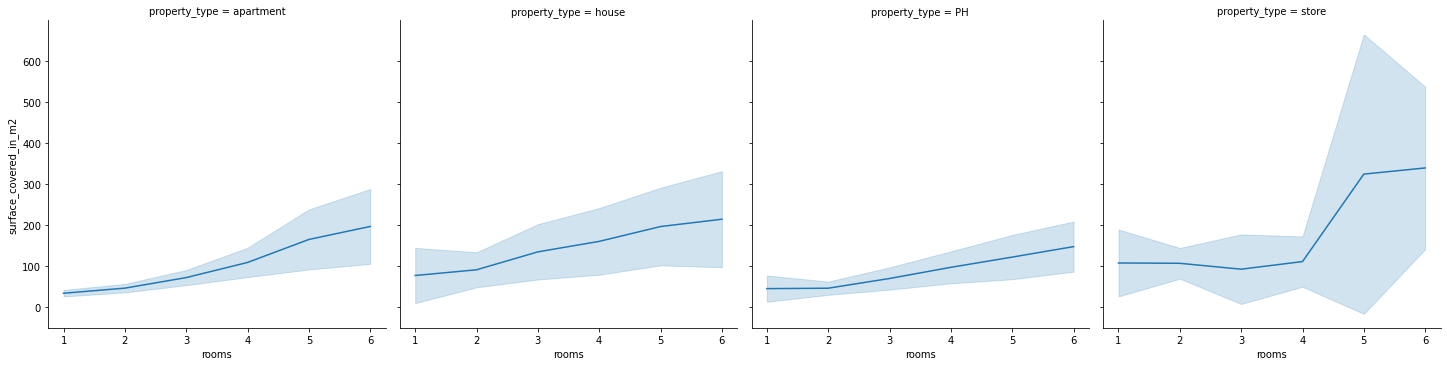

Relación nueva variable rooms_expanded con superficie cubierta
registros: 66366
correlación :0.6606820601711976


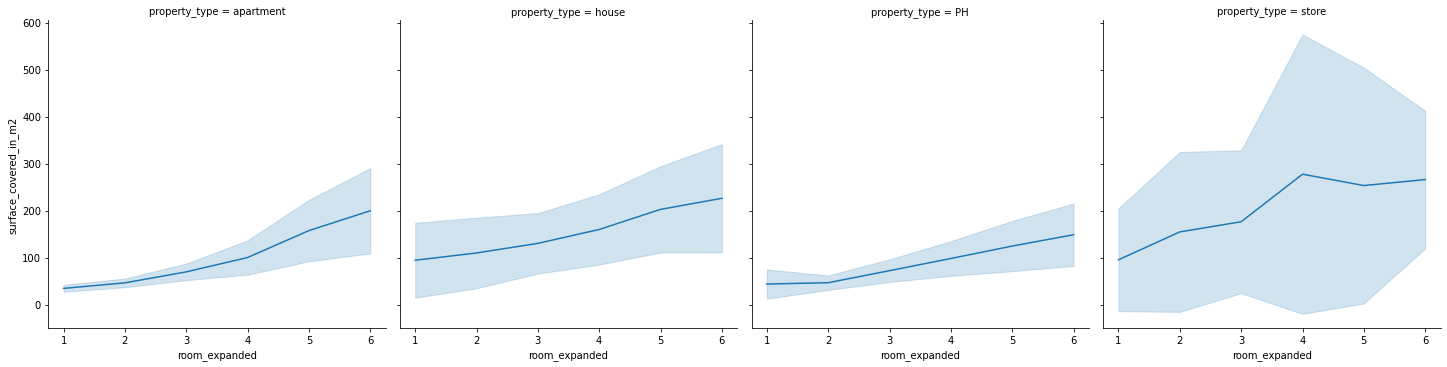

In [132]:
#Relación rooms con 'surface_covered_in_m2' antes (linea 1) y despues de completar datos (linea 2) sin outliers
data2_s = no_outliers_surf_cov.loc[data.room_expanded <7]

print('Relación rooms original con superficie cubierta')
print('registros: '+str(data1_s.shape[0]) )
print('correlación :'+str(data1_s['surface_covered_in_m2'].corr(data1_s.rooms.astype(float))))

sns.relplot(
    data=data1_s,
    x="rooms", y="surface_covered_in_m2", col="property_type", col_order=['apartment','house','PH','store'],
    kind="line", ci='sd'
)
plt.show()
print('Relación nueva variable rooms_expanded con superficie cubierta')
print('registros: '+str(data2_s.shape[0]) )
print('correlación :'+str(data2_s['surface_covered_in_m2'].corr(data2_s.room_expanded.astype(float))))

sns.relplot(
    data=data2_s,
    x="room_expanded", y="surface_covered_in_m2", col="property_type",col_order=['apartment','house','PH','store'],
    kind="line", ci='sd'
);

#Se mantiene en general la forma con menos dispersion, salvo en el caso de store
#Para 1 y 2 ambientes sube la media de houses y se genera más dispersión

In [48]:
#Revisar valores como lista vs original en surface covered
list_values=['surface_covered_in_m2','surface_total_in_m2', 'price_usd_per_m2']
df_rooms = data2_s[data2_s.property_type=='house'].groupby(['rooms']).agg({'surface_covered_in_m2':['mean','std'], 'operation':'count'})
df_room_expanded = data2_s[data2_s.property_type=='house'].groupby(['room_expanded']).agg({'surface_covered_in_m2':['mean','std'], 'operation':'count'})
df_room_expanded.join(other=df_rooms, rsuffix='_original')



surface_covered_in_m2             operation  \
                               mean         std     count   
room_expanded                                               
1.0                       94.450909   79.779625       356   
2.0                      109.878069   75.189684      1389   
3.0                      130.335641   64.411982      4339   
4.0                      159.923400   74.841040      4489   
5.0                      202.683794   91.863217      3001   
6.0                      226.292733  115.392480      1234   

              surface_covered_in_m2_original             operation_original  
                                        mean         std              count  
room_expanded                                                                
1.0                                79.512195   66.539507                250  
2.0                                93.098707   44.159120                980  
3.0                               135.406960   67.257480               3181  
4.0                               160.087872   80.379008               3238  
5.0                               196.170461   94.301809               2266  
6.0                               215.396825  117.674379                978

Relación rooms original con precio en USD
registros: 43760
correlación :0.3125242047570396


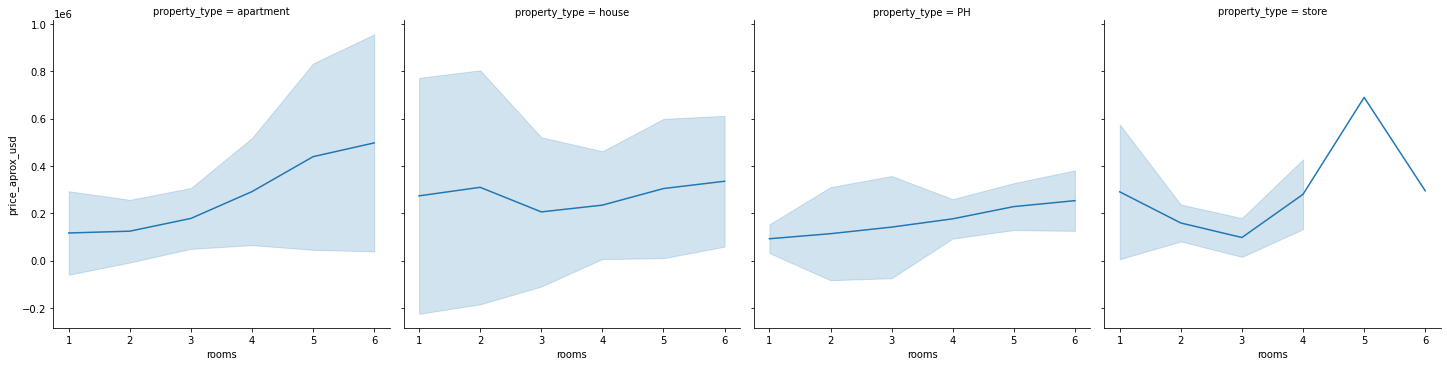

Relación nueva variable rooms_expanded con precio en USD
registros: 67294
correlación :0.3569141737287113


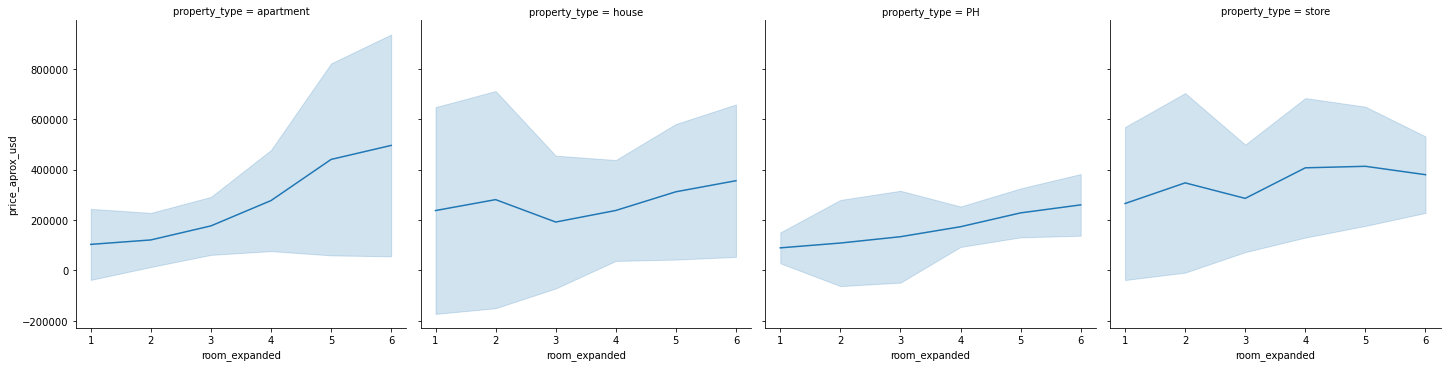

In [134]:
#Preparo set de datos sin outliers para precio
mask_no_outliers_price = no_outliers(['property_type','room_expanded','state_name'],'price_usd_per_m2',data )
no_outliers_price=data.loc[mask_no_outliers_price]

#Relación rooms con 'price_usd_per_m2' antes (linea 1) y despues de completar datos (linea 2)
#Corregir para que agarre sin outliers de precio
data2_p = no_outliers_price.loc[data.room_expanded <7]

print('Relación rooms original con precio en USD')
print('registros: '+str(data1_p.shape[0]) )
print('correlación :'+str(data1_p['price_aprox_usd'].corr(data2_p.rooms.astype(float))))


sns.relplot(
    data=data1_p,
    x="rooms", y="price_aprox_usd", col="property_type",col_order=['apartment','house','PH','store'],
    kind="line",ci='sd'
)
plt.show()

print('Relación nueva variable rooms_expanded con precio en USD')
print('registros: '+str(data2_p.shape[0]) )
print('correlación :'+str(data2_p['price_aprox_usd'].corr(data2_p.room_expanded.astype(float))))

sns.relplot(
    data=data2_p,
    x="room_expanded", y="price_aprox_usd", col="property_type",col_order=['apartment','house','PH','store'],
    kind="line",ci='sd'
);

<a id="ambientes3"></a>
### Etapa 3: Inferir ambientes desde dormitorios

#### 3.1 Extracción dormitorios desde description

In [135]:
#Extraer Dormitorios en 'description'
pattern_dorm = '(?:^|\s+)(?P<dorm>\d) Dorm'

values_dorm, mask_dorm = search_extract(pattern_dorm,'dorm',data['description'])
values_dorm=values_dorm.astype(int)
mask_dorm.sum(), mask_dorm.value_counts()

(37263,
 False    83957
 True     37263
 Name: description, dtype: int64)

In [136]:
#Agrego la columna dorm al dataset
data.loc[mask_dorm, 'dorm']=values_dorm

In [137]:
#Reviso distribución por property_type
data[mask_dorm]['property_type'].value_counts()

house        18570
apartment    16520
PH            1967
store          206
Name: property_type, dtype: int64

#### 3.4 Relación dorm con rooms

Se analiza cual es la relación entre los dormitorios y los ambientes de los inmuebles

Relación dorm (extraido de description) con rooms


0.5228588887177702

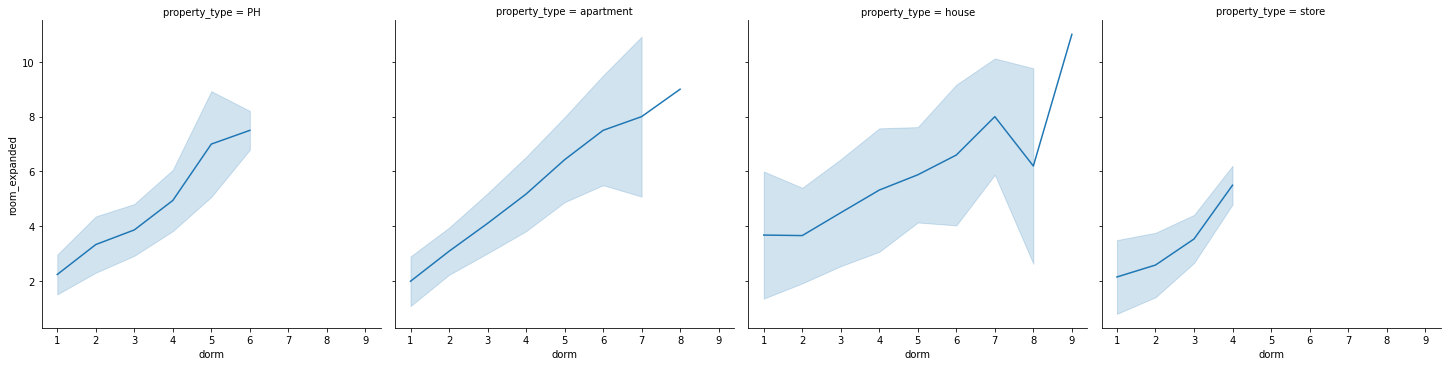

In [140]:
#Grafico la relación dorm con room_expanded
print('Relación dorm (extraido de description) con rooms')
sns.relplot(
    data=data,
    x="dorm", y="room_expanded", col="property_type",
    kind="line", ci='sd', dashes=False
);
data.room_expanded.corr(data.dorm)

Relación dorm (extraido de description) con rooms para departamentos


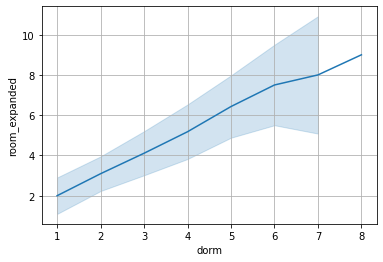

0.6900686410387017


In [142]:
print('Relación dorm (extraido de description) con rooms para departamentos')

sns.lineplot(data=data.loc[data.property_type=='apartment'], x='dorm', y='room_expanded', ci='sd')
plt.grid()
plt.show()
print(data[data.property_type=='apartment'].room_expanded.corr(data[data.property_type=='apartment'].dorm))
#Para apartment es una linea recta entre dorm y room expanded. Usar para completar los que faltan como amb = dorm +1

Detalle ambientes para departamentos de 2 dormitorios


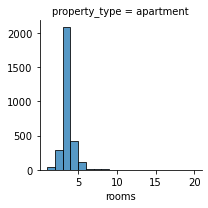

In [143]:
#Graficar Cantidad de ambientes para departamentos con 2 dormitorios
print('Detalle ambientes para departamentos de 2 dormitorios')
g = sns.FacetGrid(data.loc[(data.property_type=='apartment')&(data.rooms.notnull())&(data.dorm==2)], col='property_type')
g.map(sns.histplot, "rooms", binwidth=1);

Relación dorm (extraido de description) con rooms para casas


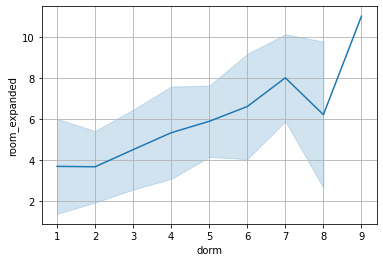

correlación: 0.2948446623097475


In [147]:
print('Relación dorm (extraido de description) con rooms para casas')
sns.lineplot(data=data.loc[data.property_type=='house'], x='dorm', y='room_expanded', ci='sd')
plt.grid()
plt.show()
#Para houses la dispersión es bastante más grande.
print('correlación: '+str(data[data.property_type=='house'].room_expanded.corr(data[data.property_type=='house'].dorm)))


Detalle ambientes para casas de 2 dormitorios


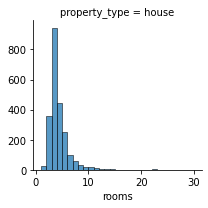

In [148]:
#Graficar Cantidad de ambientes para casas con 2 dormitorios
print('Detalle ambientes para casas de 2 dormitorios')

g = sns.FacetGrid(data.loc[(data.property_type=='house')&(data.rooms.notnull())&(data.dorm==2)], col='property_type')
g.map(sns.histplot, "rooms", binwidth=1);

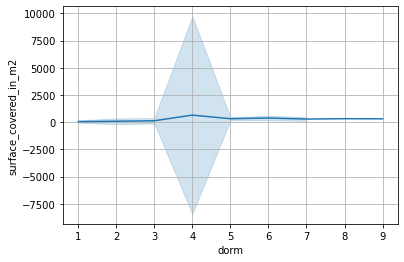

In [149]:
#Revisar surface en función de dorm para apartment
sns.lineplot(data=data.loc[data.property_type=='apartment'], x='dorm', y='surface_covered_in_m2', ci='sd')
plt.grid()
#Tengo un valor outlier en 4 dorms que me altera mucho la distribución

In [150]:
#Revisar casos de 4 dorms
data.loc[data.dorm==4].loc[data.property_type=='apartment'][['price_aprox_usd','surface_covered_in_m2','description','price_usd_per_m2']].sort_values(by='surface_covered_in_m2',ascending=False).head(10)

#Hay datos sucios como surface 187000m2

price_aprox_usd  surface_covered_in_m2  \
76012          600000.0               187000.0   
58175         6000000.0                  684.0   
47109         2499000.0                  655.0   
47399         4200000.0                  592.0   
46392         2499000.0                  500.0   
109845              NaN                  500.0   
52788         5500000.0                  456.0   
52789         5500000.0                  456.0   
53048         5500000.0                  456.0   
53116         5500000.0                  456.0   

                                              description  price_usd_per_m2  
76012   Barrio Norte EXCELENTE Semipiso al Frente Balc...               NaN  
58175   TRIPLEX EN FORUM ALCORTA! VISTA ESPECTACULAR A...       8771.929825  
47109   Corredor Responsable: Ricardo Demichelli - CUC...               NaN  
47399   SLS PUERTO MADERO es un emprendimiento en altu...       7094.594595  
46392   Vende hermoso pent house duplex de categoria e...       3815.267176  
109845  Impresionante PentHouse en torre de categoría ...               NaN  
52788   Espectacular Penthouse en Forum Alcorta! Trilp...      10658.914729  
52789   Espectacular Penthouse en Forum Alcorta! Trilp...      10658.914729  
53048   Espectacular Penthouse en Forum Alcorta! Trilp...      10638.297872  
53116   Espectacular Penthouse en Forum Alcorta! Trilp...      10638.297872

In [151]:
#Revisar caso outlier: Eran 187m2 y surface_covered_in_m2 dice 187000
data.loc[76012]['description']

'Barrio Norte EXCELENTE Semipiso al Frente Balcón Corrido Superficie 187 metros todos los Ambientes Muy Luminosos y Soleados - Palier privado.  4 dormitorios - c/dependencia servicio - 4 bañosRecepción y Comedor,Cocina con Comedor Diario y Lavadero Cochera Fija y gran Baulera Sercios Centrales Edificio con Entrada de Cortesía Expensas Incluye Aysa y Vigilancia $11.000.- '

#### 3.3 Agregar al dataset

Dado que la correlación es mucho mayor para departamentos, vamos a completar rooms con dorm+1 únicamente para deptos

In [152]:
#Genero una serie con ambientes desde room donde ambientes es room+1
#Por el momento solo para apartments que tenian la mayor relación
values_amb_from_dorm = values_dorm.map(lambda x: x+1)
values_amb_from_dorm.shape, values_amb_from_dorm.value_counts()

((37263,),
 3     14949
 4     11601
 2      7107
 5      3035
 6       466
 7        70
 8        21
 9         9
 10        5
 Name: description, dtype: int64)

In [153]:
#Completo 'room_expanded_2' con 'dorm' en los casos que todavia no tenia valor
#Por el momento únicamente para apartments que era donde había mayor relación
mask_no_room_expanded = data['room_expanded'].isnull()
mask_apartment = data['property_type']=='apartment'
mask = mask_no_room_expanded & mask_dorm &mask_apartment
data['room_expanded_2']=data['room_expanded']
data.loc[mask,'room_expanded_2'] =values_amb_from_dorm[mask]
mask.sum(), data['room_expanded_2'].notnull().sum()

(6620, 78284)

In [154]:
data[mask]['property_type'].value_counts()

apartment    6620
Name: property_type, dtype: int64

In [155]:
#columna 'room_cat' que agrupa de 6+ rooms en una misma categoria
data['room_cat']=data['room_expanded_2'].map(lambda x: '6+' if x>5 else x)

In [156]:
data['room_cat'].shape

(121220,)

#### 3.4 Revisión de nuevas distribuciones

In [157]:
#Filtrar outliers de surface_covered_in_m2 por property_type y room_cat
mask_no_outliers = no_outliers(['property_type','room_cat','state_name'],'surface_covered_in_m2', data)
data_without_outliers_surface_covered=data[mask_no_outliers]

Relación rooms original con superficie cubierta
registros: 43447
correlación :0.6741922237301556


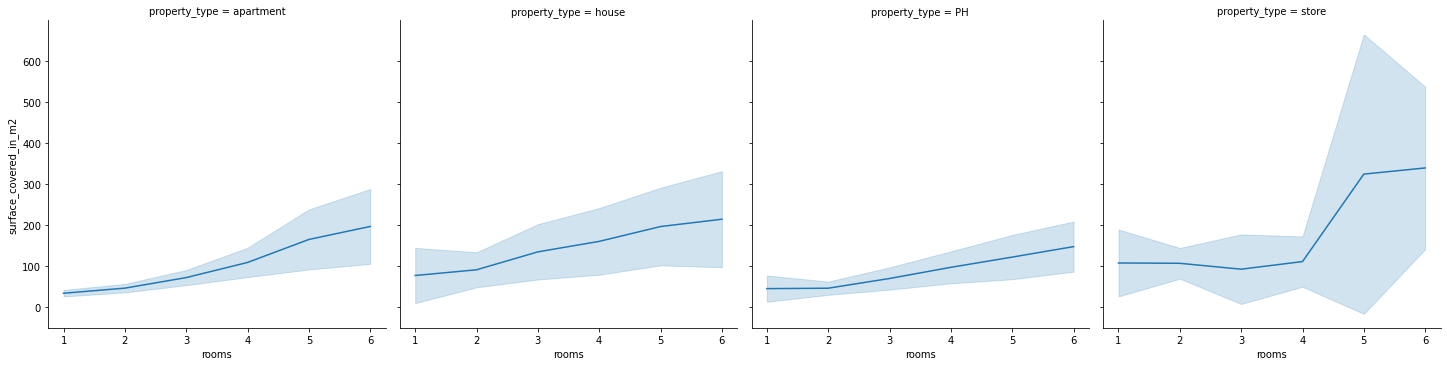

Relación room_expanded (+ ambientes en descripción) con superficie cubierta
registros: 66366
correlación :0.6606820601711976


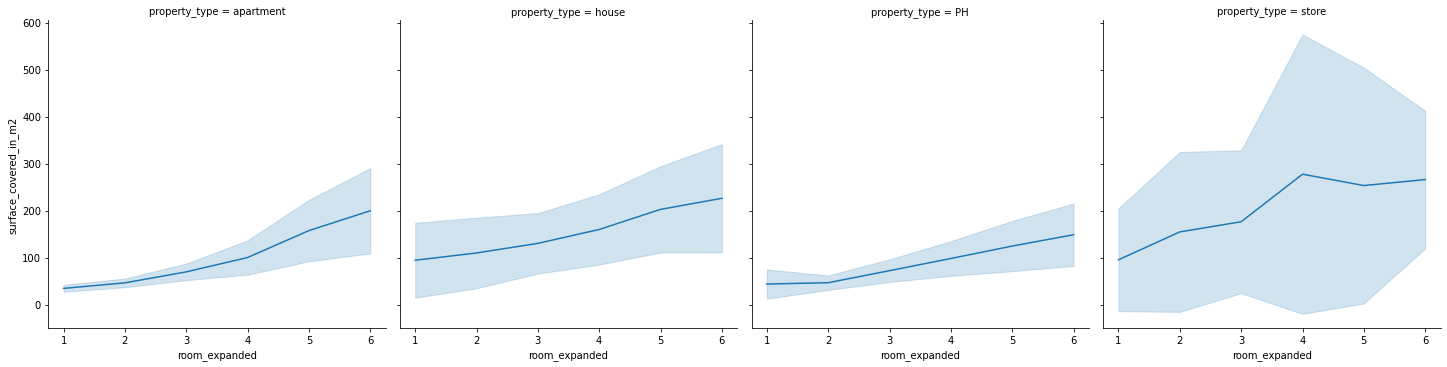

Relación room_expanded (+ ambientes y dormitorios en descripción) con superficie cubierta
registros: 72673
correlación :0.6613414045526622


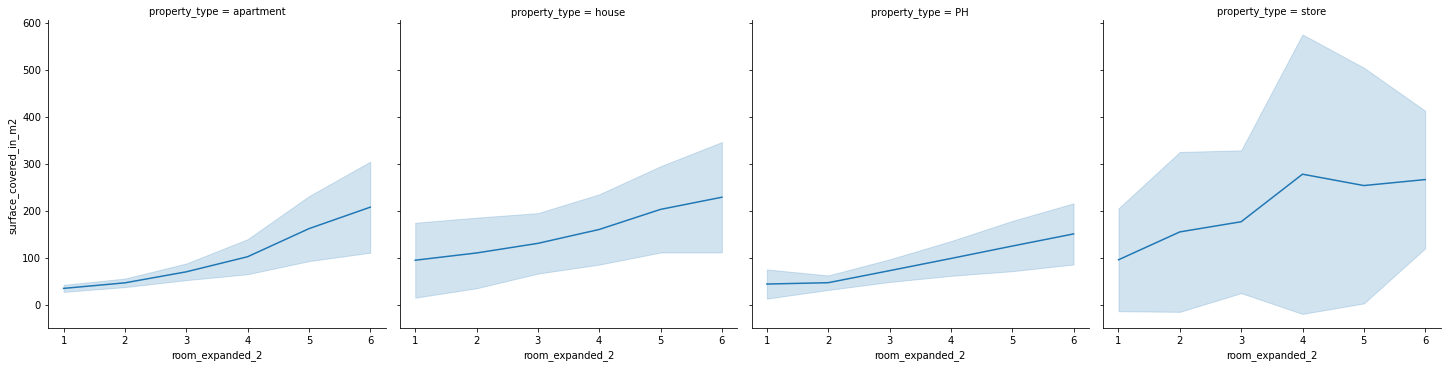

In [159]:
data3_s=data_without_outliers_surface_covered.loc[data_without_outliers_surface_covered.room_expanded_2<7]

#Graficar relación entre surface_covered_in_m2 y rooms en las 3 etapas de completar datos
#1) rooms original
#2) room_expanded con Ambientes
#3) room_expanded_2 con Dorm
print('Relación rooms original con superficie cubierta')
print('registros: '+str(data1_s.shape[0]) )
print('correlación :'+str(data1_s['surface_covered_in_m2'].corr(data1_s.rooms.astype(float))))

#Grafico rooms original
sns.relplot(
    data=data1_s,
    x="rooms", y="surface_covered_in_m2", col="property_type", col_order=['apartment','house','PH','store'],
    kind="line", ci='sd'
)
plt.show()

#Grafico con room_expanded

print('Relación room_expanded (+ ambientes en descripción) con superficie cubierta')
print('registros: '+str(data2_s.shape[0]) )
print('correlación :'+str(data2_s['surface_covered_in_m2'].corr(data2_s.room_expanded.astype(float))))

sns.relplot(
    data=data2_s,
    x="room_expanded", y="surface_covered_in_m2", col="property_type", col_order=['apartment','house','PH','store'],
    kind="line", ci='sd'
)
plt.show()


#Grafico con room_expanded_2

print('Relación room_expanded (+ ambientes y dormitorios en descripción) con superficie cubierta')
print('registros: '+str(data3_s.shape[0]) )
print('correlación :'+str(data3_s['surface_covered_in_m2'].corr(data3_s.room_expanded_2.astype(float))))

sns.relplot(
    data=data3_s,
    x="room_expanded_2", y="surface_covered_in_m2", col="property_type", col_order=['apartment','house','PH','store'],
    kind="line", ci='sd'
)
plt.show()
#Apartment y ph mantiene la misma forma
#House revisar porque se altera bastante. Store no parece tener sentido mirar rooms

In [162]:
#Filtrar outliers de price_aprox_usd por property_type y room_cat
mask_no_outliers_price=no_outliers(['property_type','room_cat','state_name'],'price_usd_per_m2', data)
data_no_outliers_price=data[mask_no_outliers_price]

Relación rooms original con precio en USD
registros: 43760
correlación :0.3129766125743041


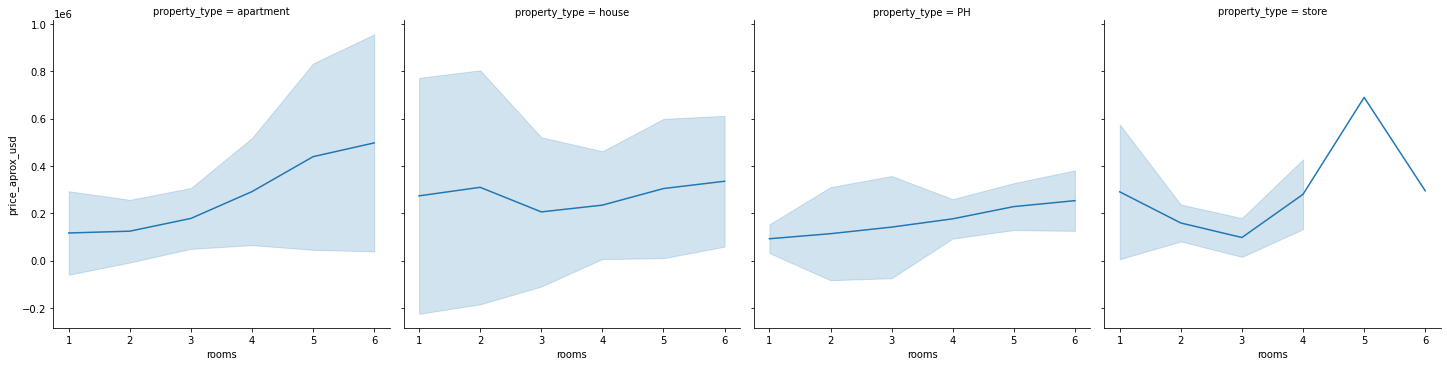

Relación rooms_expanded (+ ambientes en descripción) con precio en USD
registros: 67294
correlación :0.3569141737287113


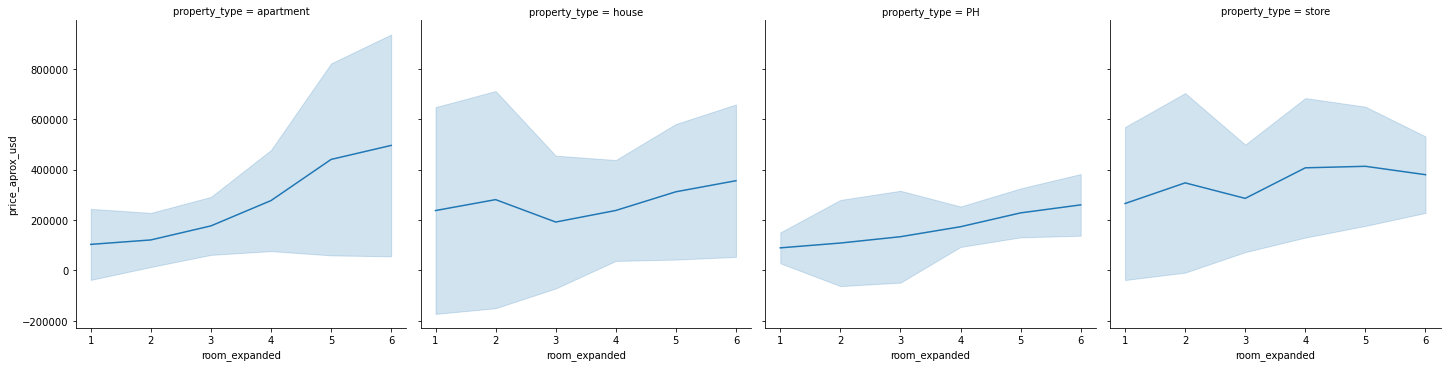

Relación rooms_expanded (+ ambientes y dormitorios en descripción) con precio en USD
registros: 73774
correlación :0.365087242621059


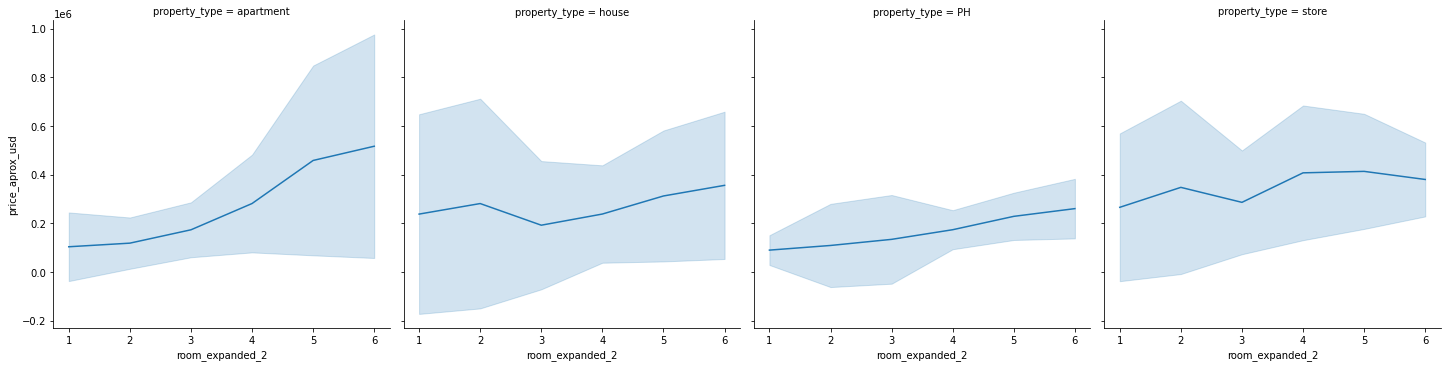

In [164]:
data3_p=data_no_outliers_price[data_no_outliers_price.room_expanded_2<7]
#Graficar relación entre price_aprox_usd y rooms en las 3 etapas de completar datos
#1) rooms original
#2) room_expanded con Ambientes
#3) room_expanded_2 con Dorm
print('Relación rooms original con precio en USD')
print('registros: '+str(data1_p.shape[0]) )
print('correlación :'+str(data1_p['price_aprox_usd'].corr(data1_p.rooms.astype(float))))

sns.relplot(
    data=data1_p,
    x="rooms", y="price_aprox_usd", col="property_type", col_order=['apartment','house','PH','store'],
    kind="line", ci='sd'
)
plt.show()

print('Relación rooms_expanded (+ ambientes en descripción) con precio en USD')
print('registros: '+str(data2_p.shape[0]) )
print('correlación :'+str(data2_p['price_aprox_usd'].corr(data2_p.room_expanded.astype(float))))

sns.relplot(
    data=data2_p,
    x="room_expanded", y="price_aprox_usd", col="property_type", col_order=['apartment','house','PH','store'],
    kind="line", ci='sd'
)
plt.show()

print('Relación rooms_expanded (+ ambientes y dormitorios en descripción) con precio en USD')
print('registros: '+str(data3_p.shape[0]) )
print('correlación :'+str(data3_p['price_aprox_usd'].corr(data3_p.room_expanded_2.astype(float))))

sns.relplot(
    data=data3_p,
    x="room_expanded_2", y="price_aprox_usd", col="property_type", col_order=['apartment','house','PH','store'],
    kind="line", ci='sd'
);

#Apartment y ph mantiene la misma forma
#Revisar House de 1 y 2 amb

### Etapa 4: Revisión de inconsistencias

In [167]:
#Casos donde los dormitorios son mayores o iguales a los ambientes
mask_dorm_room = data.dorm>data.room_expanded_2 - 1
mask_dorm_room.sum(), data[mask_dorm_room]['property_type'].value_counts()

(3337,
 house        1659
 apartment    1564
 PH             98
 store          16
 Name: property_type, dtype: int64)

In [168]:
data[mask_dorm_room].head(5)

Unnamed: 0 operation property_type  place_name  \
11          11      sell         house  San Miguel   
84          84      sell     apartment     Rosario   
85          85      sell     apartment     Rosario   
87          87      sell         house     Córdoba   
88          88      sell     apartment     Córdoba   

                            place_with_parent_names country_name  \
11  |Argentina|Bs.As. G.B.A. Zona Norte|San Miguel|    Argentina   
84                     |Argentina|Santa Fe|Rosario|    Argentina   
85                     |Argentina|Santa Fe|Rosario|    Argentina   
87                      |Argentina|Córdoba|Córdoba|    Argentina   
88                      |Argentina|Córdoba|Córdoba|    Argentina   

                  state_name  geonames_id                  lat-lon        lat  \
11  Bs.As. G.B.A. Zona Norte          NaN  -34.5390571,-58.7196093 -34.539057   
84                  Santa Fe    3838574.0  -32.9327656,-60.6533854 -32.932766   
85                  Santa Fe    3838574.0  -32.9588372,-60.6456409 -32.958837   
87                   Córdoba    3860259.0  -31.4253708,-64.1577465 -31.425371   
88                   Córdoba    3860259.0  -31.3987492,-64.1918878 -31.398749   

    ...                                        description  \
11  ...  Entrada de Coche, Jardin, Living en desnivel, ...   
84  ...  Departamento en PB con cocina comedor separado...   
85  ...  Corrientes 1900 – 1º Piso Departamento de 1 do...   
87  ...                Casa en Venta de 3 dorm. en Cordoba   
88  ...        Departamento en Venta de 1 dorm. en Cordoba   

                                                title  \
11                                            CHALET    
84                      2 Dormitorios. Güemes al 2400   
85  Corrientes 1900 – 1º Piso  1 dormitorio (semip...   
87                Casa en Venta de 3 dorm. en Cordoba   
88              Cofico 1d con terraza ppia con asador   

                                      image_thumbnail  mono_desc  \
11  https://thumbs4.properati.com/4/pH0MnS_2zCGOHR...        NaN   
84  https://thumbs4.properati.com/3/p47wDv3RcA2Ppe...        NaN   
85  https://thumbs4.properati.com/8/Gc4BDlZf59gKpg...        NaN   
87  https://thumbs4.properati.com/6/6eKnjn3cRn_YKa...        NaN   
88  https://thumbs4.properati.com/7/zLBENHoruvv1EA...        NaN   

    amb_text_desc  amb_num_desc  room_expanded  dorm  room_expanded_2  \
11            NaN           1.0            1.0   2.0              1.0   
84            NaN           NaN            2.0   2.0              2.0   
85            NaN           NaN            1.0   1.0              1.0   
87            NaN           NaN            2.0   3.0              2.0   
88            NaN           NaN            1.0   1.0              1.0   

    room_cat  
11         1  
84         2  
85         1  
87         2  
88         1  

[5 rows x 33 columns]

In [169]:
#Reemplazar estos casos con dorm+1
data['room_fixed']=data['room_expanded_2']
data.loc[mask_dorm_room,'room_fixed']=data.loc[mask_dorm_room]['dorm'].map(lambda x:x+1)

In [170]:
#Casos donde los ambientes de la descripcion son mayores a room
mask_room_desc = (data.room_fixed<data.amb_num_desc)
mask_room_desc.sum(), data[mask_room_desc]['property_type'].value_counts()

(1615,
 apartment    1373
 house         198
 PH             40
 store           4
 Name: property_type, dtype: int64)

In [171]:
#Revisar casos
data.loc[mask_room_desc,['rooms','room_fixed','room_expanded','room_expanded_2','amb_num_desc','amb_text_desc','mono_desc','title','description']].sample(5)

rooms  room_fixed  room_expanded  room_expanded_2  amb_num_desc  \
47046    4.0         4.0            4.0              4.0           5.0   
38405    3.0         3.0            3.0              3.0           4.0   
7958     1.0         1.0            1.0              1.0           3.0   
43933    4.0         4.0            4.0              4.0           5.0   
8034     1.0         1.0            1.0              1.0           2.0   

       amb_text_desc  mono_desc  \
47046            NaN        NaN   
38405            NaN        NaN   
7958             NaN        NaN   
43933            4.0        NaN   
8034             NaN        1.0   

                                                  title  \
47046                                       PH EN VENTA   
38405  Torre The Edge - Barrio Norte - 3 amb (opc Coch)   
7958                        Departamento - Palermo Soho   
43933       KLOVER PLAZA! LA SEGURIDAD DE TENERLO TODO!   
8034      Se estrena Excelente Monoambiente - Monserrat   

                                             description  
47046  Excelente departamento tipo casa de 5 ambiente...  
38405  AMENITIES: Terraza con Solarium - Piscina desc...  
7958   A solo 1 cuadra de Av Córdoba y 2 de Honduras,...  
43933  Klover Plaza es un proyecto totalmente innovad...  
8034   Monoambiente / ContrafrenteCaracterísticasEl e...

In [172]:
#Se decide no reemplazar ya que pueden ser inconsistencias de la extracción y no de los datos originales

#Pisar valores con amb_num_desc
#data.loc[mask_room_desc,'room_fixed']=data.loc[mask_room_desc,'amb_num_desc']

In [173]:
#House 1 amb
data.loc[(data.property_type=='house') & (data.room_fixed==1),'room_fixed'].shape

(245,)

In [174]:
data.loc[(data.property_type=='house') & (data.room_fixed==1),'room_fixed']=np.NaN
data.room_fixed.notnull().sum()

78039

In [175]:
#Actualizar room_cat
data['room_cat']=data['room_fixed'].map(lambda x: '6+' if x>5 else x)

<a id="ambientes5"></a>
### 3.5 Distribuciones Finales

In [176]:
list_rooms=['rooms','room_expanded','room_expanded_2','room_fixed']

In [177]:
data[list_rooms].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121220 entries, 0 to 121219
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   rooms            47390 non-null  float64
 1   room_expanded    71664 non-null  float64
 2   room_expanded_2  78284 non-null  float64
 3   room_fixed       78039 non-null  float64
dtypes: float64(4)
memory usage: 3.7 MB


In [178]:
data[list_rooms].apply(lambda x:x.notnull().sum()/data.shape[0])

rooms              0.390942
room_expanded      0.591190
room_expanded_2    0.645801
room_fixed         0.643780
dtype: float64

De esta forma pasamos de un 39% de registros con rooms a un 64%.

Pendiente: investigar si correr los mismos patrones en el campo title nos traerian registros adicionales con rooms

Distribución original de rooms


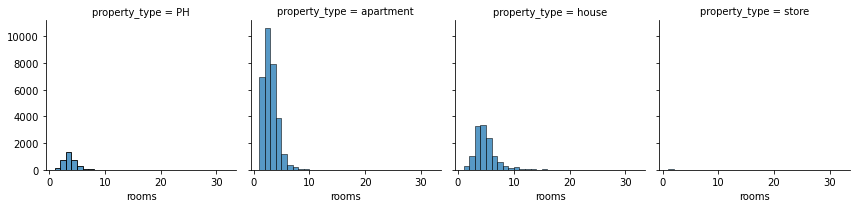

In [179]:
#Distribucion original
print('Distribución original de rooms')
g=sns.FacetGrid(data,col='property_type')
g.map(sns.histplot, 'rooms',binwidth=1);

Nueva distribución de rooms


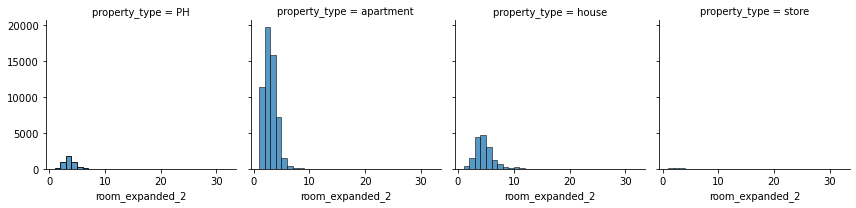

In [180]:
#Distribucion con room_expanded_2
print('Nueva distribución de rooms (+ambientes y dormitorios en descripcion)')
g=sns.FacetGrid(data,col='property_type')
g.map(sns.histplot, 'room_expanded_2',binwidth=1);

Nueva distribución de rooms con correcciones


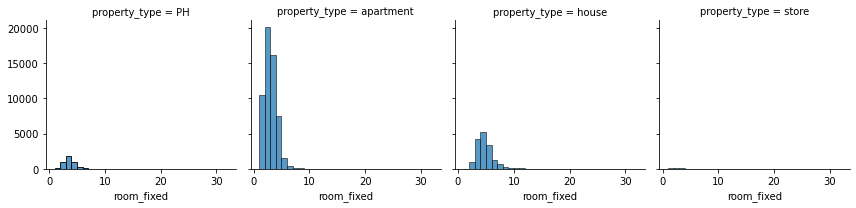

In [181]:
#Distribucion final con room_fixed
print('Nueva distribución de rooms con correcciones')
g=sns.FacetGrid(data,col='property_type')
g.map(sns.histplot, 'room_fixed',binwidth=1);

In [182]:
data.pivot_table(values='operation', aggfunc='count', columns='property_type', index='room_fixed').head(10)


property_type      PH  apartment   house  store
room_fixed                                     
1.0             121.0    10513.0     NaN   88.0
2.0             967.0    20073.0   987.0   88.0
3.0            1828.0    16097.0  4227.0   90.0
4.0             975.0     7547.0  5249.0   52.0
5.0             327.0     1591.0  3349.0   12.0
6.0              88.0      381.0  1318.0    7.0
7.0              27.0      192.0   677.0    9.0
8.0              12.0       92.0   323.0    2.0
9.0               5.0       37.0   158.0    1.0
10.0              4.0       23.0   197.0    3.0

Relación rooms original con superficie cubierta
registros: 43447
correlación :0.6741922237301556


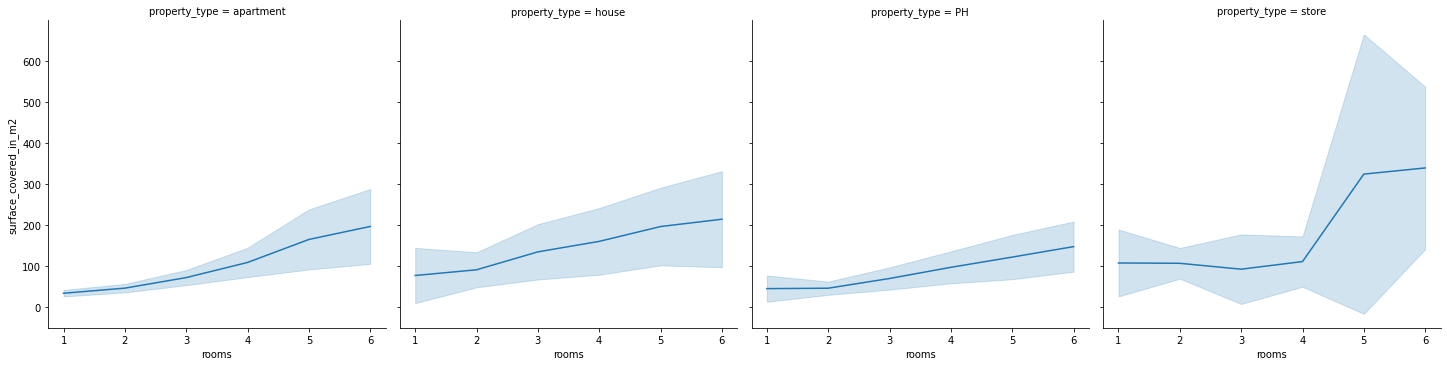

Relación rooms_expanded (+ ambientes en descripción) con superficie cubierta
registros: 66366
correlación :0.6606820601711976


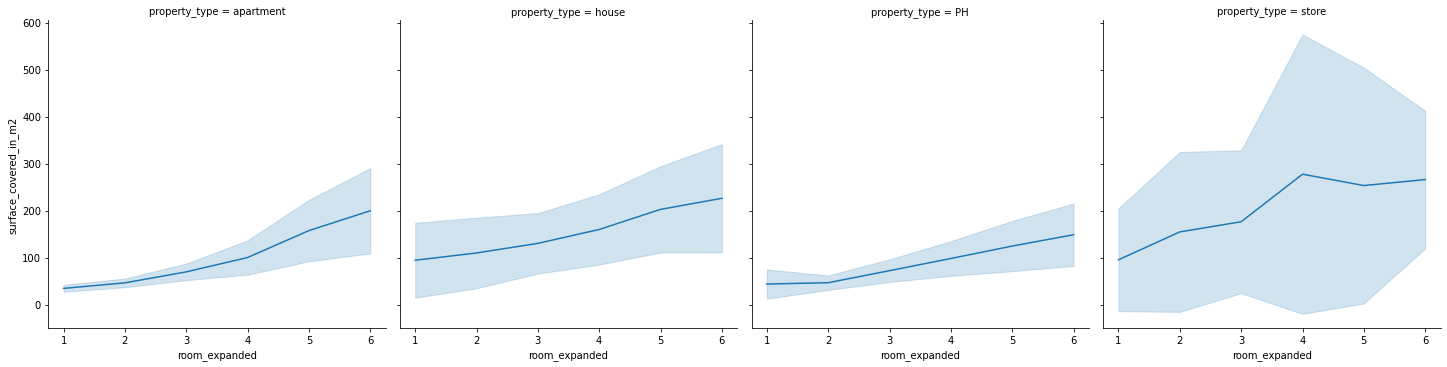

Relación rooms_expanded (+ ambientes y dormitorios en descripción) con superficie cubierta
registros: 72673
correlación :0.6613414045526622


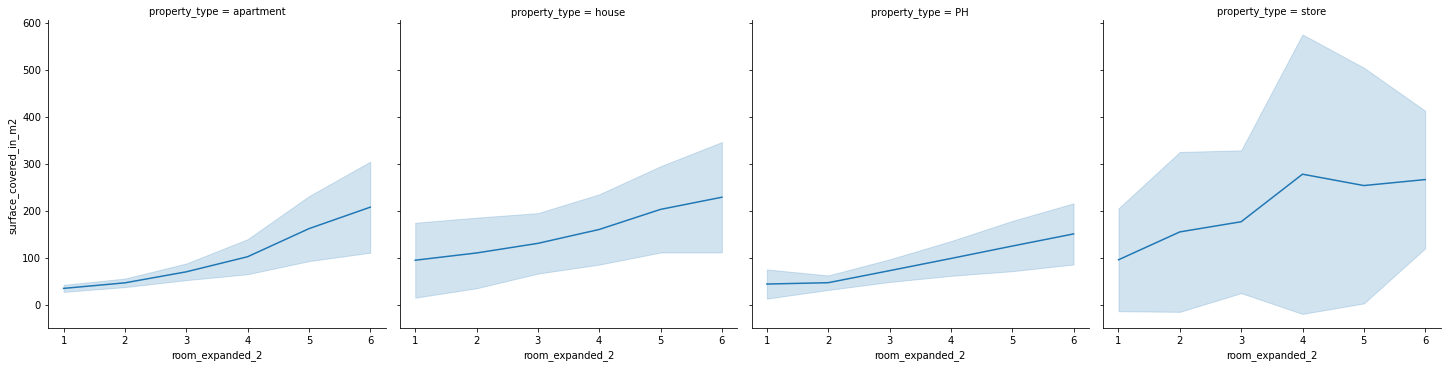

Relación rooms corregido con superficie cubierta
registros: 72492
correlación :0.6946493028646993


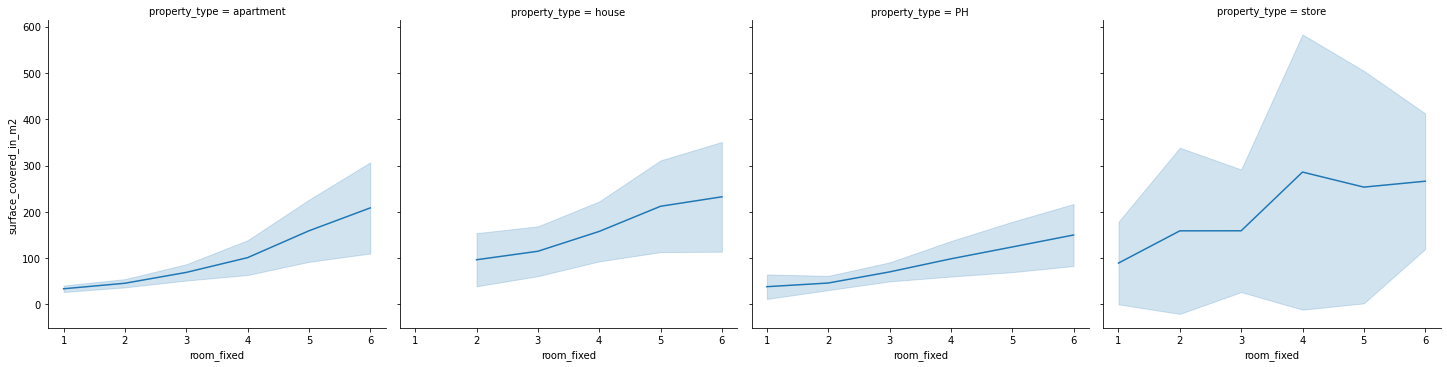

In [217]:
#Filtrar outliers de price_aprox_usd por property_type y room_cat
mask_no_outliers_surf=no_outliers(['property_type','room_fixed','state_name'],'surface_covered_in_m2', data)
data_no_outliers_surf=data[mask_no_outliers_surf]


data4_s=data_no_outliers_surf[data_no_outliers_surf.room_fixed<7]
#Graficar relación entre surface_covered_in_m2 y rooms en las 4 etapas de completar datos
#1) rooms original
#2) room_expanded con Ambientes
#3) room_expanded_2 con Dorm


#Grafico rooms original
print('Relación rooms original con superficie cubierta')
print('registros: '+str(data1_s.shape[0]) )
print('correlación :'+str(data1_s['surface_covered_in_m2'].corr(data1_s.rooms.astype(float))))


sns.relplot(
    data=data1_s,
    x="rooms", y="surface_covered_in_m2", col="property_type", col_order=['apartment','house','PH','store'],
    kind="line", ci='sd'
)
plt.show()

#Graficar room_expanded (+ambientes en description)
print('Relación rooms_expanded (+ ambientes en descripción) con superficie cubierta')
print('registros: '+str(data2_s.shape[0]) )
print('correlación :'+str(data2_s['surface_covered_in_m2'].corr(data2_s.room_expanded.astype(float))))


sns.relplot(
    data=data2_s,
    x="room_expanded", y="surface_covered_in_m2", col="property_type", col_order=['apartment','house','PH','store'],
    kind="line", ci='sd'
)

plt.show()

#Graficar room_expanded_2 (+ambientes y dormitorios description)

print('Relación rooms_expanded (+ ambientes y dormitorios en descripción) con superficie cubierta')
print('registros: '+str(data3_s.shape[0]) )
print('correlación :'+str(data3_s['surface_covered_in_m2'].corr(data3_s.room_expanded_2.astype(float))))


sns.relplot(
    data=data3_s,
    x="room_expanded_2", y="surface_covered_in_m2", col="property_type", col_order=['apartment','house','PH','store'],
    kind="line", ci='sd'
)

plt.show()

#Graficar room_fixed con correcciones


print('Relación rooms corregido con superficie cubierta')
print('registros: '+str(data4_s.shape[0]) )
print('correlación :'+str(data4_s['surface_covered_in_m2'].corr(data4_s.room_fixed.astype(float))))

sns.relplot(
    data=data4_s,
    x="room_fixed", y="surface_covered_in_m2", col="property_type", col_order=['apartment','house','PH','store'],
    kind="line", ci='sd'
);

118750
Relación rooms original con precio en USD
registros: 43760
correlación :0.3129766125743041


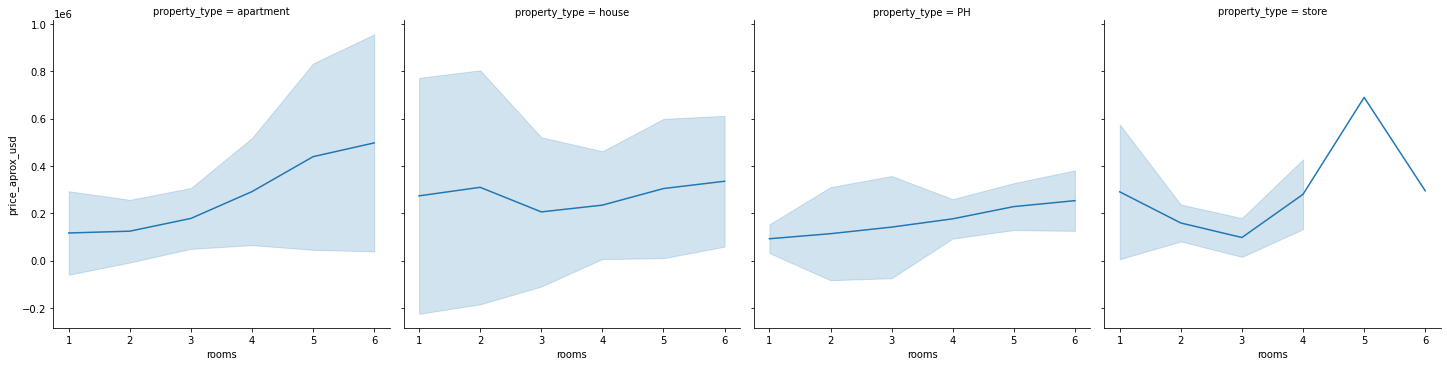

Relación rooms_expanded (+ ambientes en descripción) con precio en USD
registros: 67294
correlación :0.3569141737287113


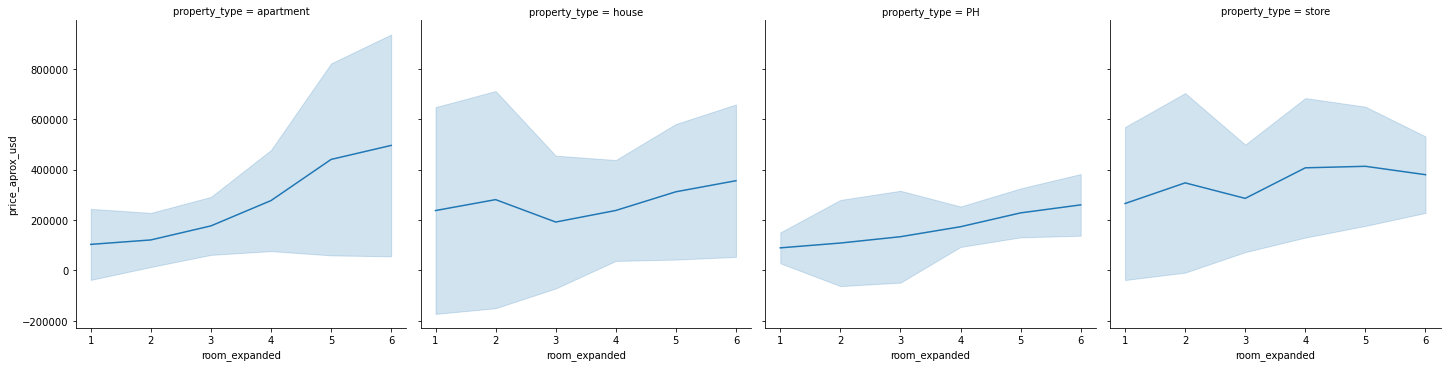

Relación rooms_expanded (+ ambientes y dormitorios en descripción) con precio en USD
registros: 73774
correlación :0.365087242621059


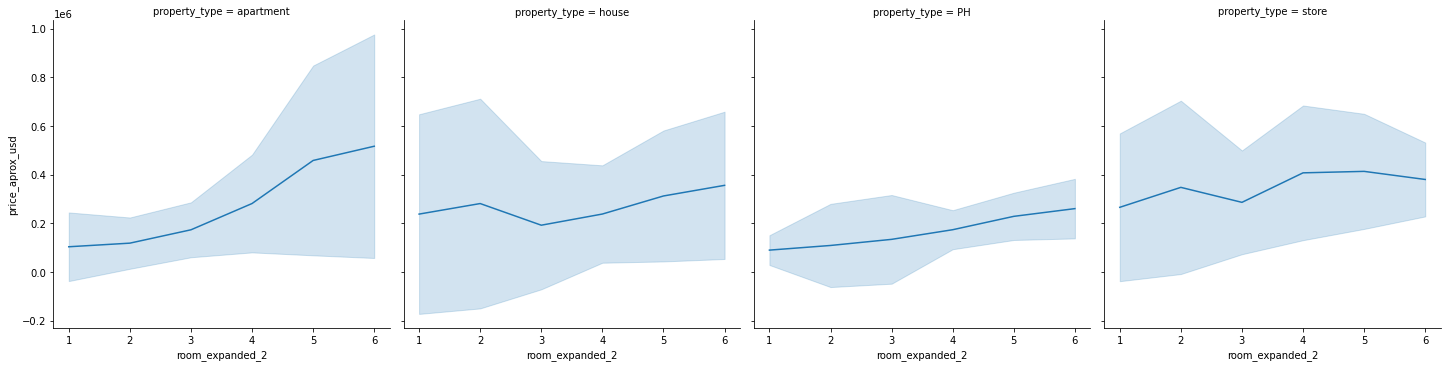

Relación rooms corregido con precio en USD
registros: 73525
correlación :0.38741822510056956


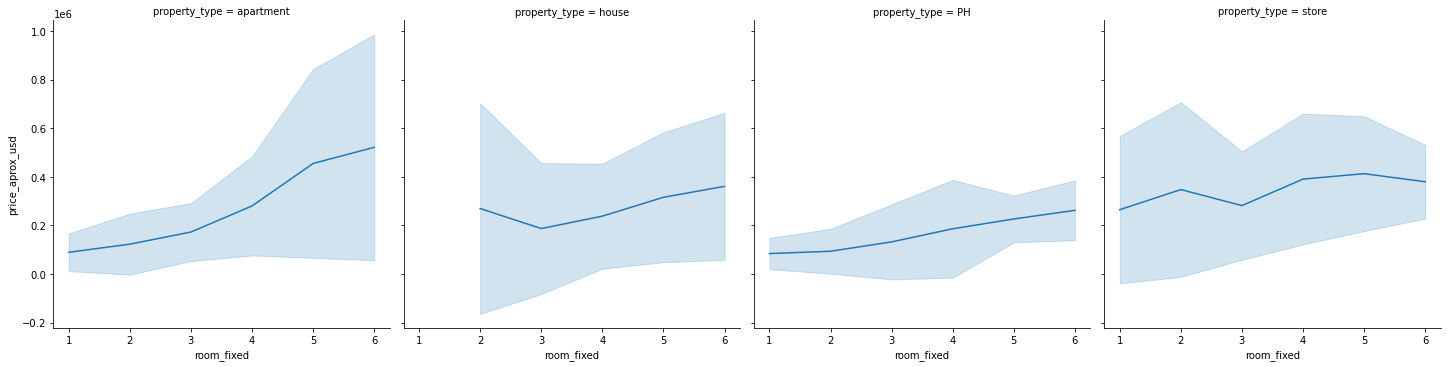

In [185]:
#Filtrar outliers de price_aprox_usd por property_type y room_cat
mask_no_outliers_price=no_outliers(['property_type','room_fixed','state_name'],'price_usd_per_m2', data)
data_no_outliers_price=data[mask_no_outliers_price]
print(mask_no_outliers_price.sum())
data4_p=data_no_outliers_price[data_no_outliers_price.room_fixed<7]

#Graficar relación entre surface_covered_in_m2 y rooms en las 4 etapas de completar datos
#1) rooms original
#2) room_expanded con Ambientes
#3) room_expanded_2 con Dorm

print('Relación rooms original con precio en USD')
print('registros: '+str(data1_p.shape[0]) )
print('correlación :'+str(data1_p['price_aprox_usd'].corr(data1_p.rooms.astype(float))))

sns.relplot(
    data=data1_p,
    x="rooms", y="price_aprox_usd", col="property_type", col_order=['apartment','house','PH','store'],
    kind="line", ci='sd'
)

plt.show()

#Graficar room_expanded (+ambientes description)
print('Relación rooms_expanded (+ ambientes en descripción) con precio en USD')
print('registros: '+str(data2_p.shape[0]) )
print('correlación :'+str(data2_p['price_aprox_usd'].corr(data2_p.room_expanded.astype(float))))

sns.relplot(
    data=data2_p,
    x="room_expanded", y="price_aprox_usd", col="property_type", col_order=['apartment','house','PH','store'],
    kind="line", ci='sd'
)

plt.show()


#Graficar room_expanded_2 (+ambientes y dormitorios description)
print('Relación rooms_expanded (+ ambientes y dormitorios en descripción) con precio en USD')
print('registros: '+str(data3_p.shape[0]) )
print('correlación :'+str(data3_p['price_aprox_usd'].corr(data3_p.room_expanded_2.astype(float))))

sns.relplot(
    data=data3_p,
    x="room_expanded_2", y="price_aprox_usd", col="property_type", col_order=['apartment','house','PH','store'],
    kind="line", ci='sd'
)

plt.show()

#Grafico final room_fixed con correcciones
print('Relación rooms corregido con precio en USD')
print('registros: '+str(data4_p.shape[0]) )
print('correlación :'+str(data4_p['price_aprox_usd'].corr(data4_p.room_fixed.astype(float))))


sns.relplot(
    data=data4_p,
    x="room_fixed", y="price_aprox_usd", col="property_type", col_order=['apartment','house','PH','store'],
    kind="line", ci='sd'
);

Distribución de superficie cubierta en m2 por ambientes


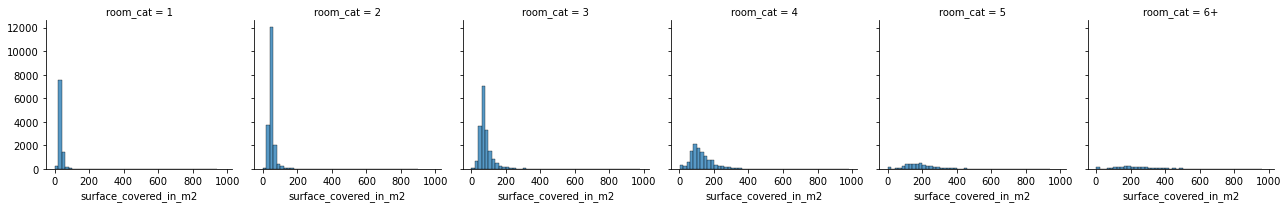

In [187]:
#Histograma superficie en funcion a room_cat

print('Distribución de superficie cubierta en m2 por ambientes')

g = sns.FacetGrid(data[data.surface_covered_in_m2<1000], col='room_cat',
                 col_order=[1,2,3,4,5,'6+'],
    )
g.map(sns.histplot, "surface_covered_in_m2", binwidth=20);

<a id="Extracciones"></a>

## Extracciones datos
- [Antigüedad](#Antig)
- [Cuotas](#Cuotas)
- [Apto Credito](#Credito)
- [Cochera](#Cochera)
- [Seguridad](#Seguridad)
- [Amenities](#Amenities)

[volver al indice](#indice)


<a id="Antig"></a>
#### Antigüedad

In [89]:
#mascara a estrenar
pattern_ae = '(?P<estrenar>a estrenar)'
values_estrenar, mask_ae = search_extract(pattern_ae, 'estrenar', data['description'])

values_estrenar.value_counts()

a estrenar    10456
Name: description, dtype: int64

In [90]:
#mascara en pozo
pattern_p = '(?P<pozo>pozo)'
values_pozo, mask_p = search_extract(pattern_p, 'pozo', data['description'])

values_pozo.value_counts()

pozo    3943
Name: description, dtype: int64

In [91]:
#mascara antigüedad
pattern_a = '(?P<antig>antigüedad|antig|antiguedad)'
values_a, mask_a = search_extract(pattern_a, 'antig', data['description'])

values_a.value_counts()
#Son muy pocos, descartar

antig         2874
antigüedad    2786
Name: description, dtype: int64

In [92]:
#Ver si se pizan pozo y a estrenar. Priorizar pozo
(mask_p&mask_ae).sum()

307

In [93]:
#Nueva serie antigüedad
antig = mask_p.apply(lambda x: 'En Pozo'if x ==True else 'Usado')
antig[mask_ae] = mask_ae[mask_ae].apply(lambda x: 'A Estrenar')

antig.value_counts()

Usado         107128
A Estrenar     10456
En Pozo         3636
Name: description, dtype: int64

In [94]:
#Nueva columna en el dataframe Antigüedad
data['antigüedad']=antig

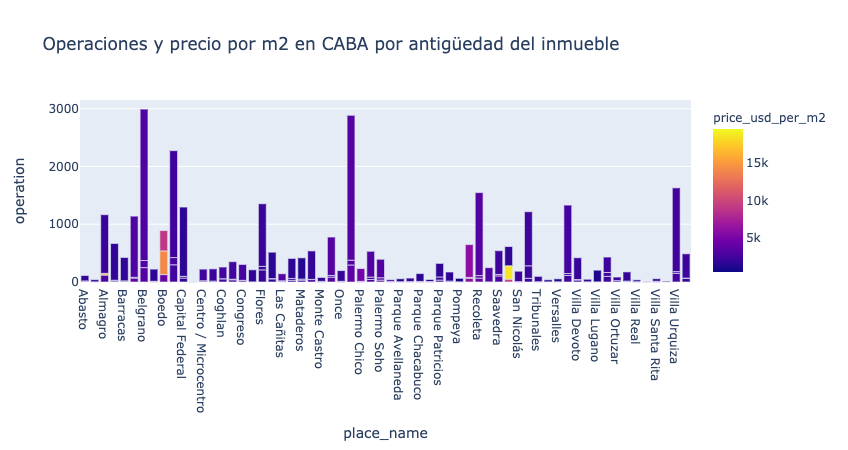

In [95]:
#Graficar por barrio CABA
df_grouped_antig=data.groupby(['state_name','place_name','antigüedad']).agg({'operation':'count','price_usd_per_m2':'mean'}).reset_index()

fig = px.bar(df_grouped_antig[df_grouped_antig.state_name=='Capital Federal'], 
             x="place_name", y="operation", color="price_usd_per_m2", 
             title="Operaciones y precio por m2 en CABA por antigüedad del inmueble", hover_data=['antigüedad'])
fig.show()

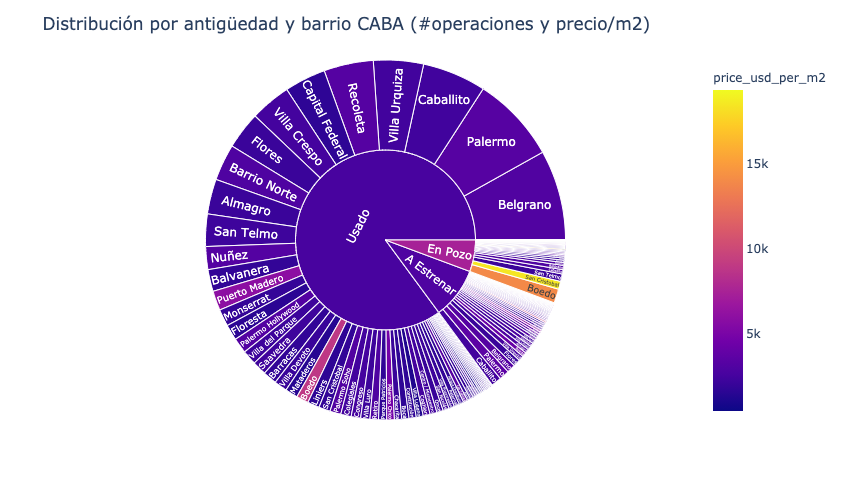

In [96]:
#Graficar por barrio CABA
fig = px.sunburst(df_grouped_antig[df_grouped_antig.state_name=='Capital Federal'].dropna(subset=['price_usd_per_m2']), 
                  path=['antigüedad','place_name'], values='operation',
                  color='price_usd_per_m2')
fig.update_layout(
    title='Distribución por antigüedad y barrio CABA (#operaciones y precio/m2)')
fig.update_layout( autosize=False, width=700, height=500,)

fig.show()

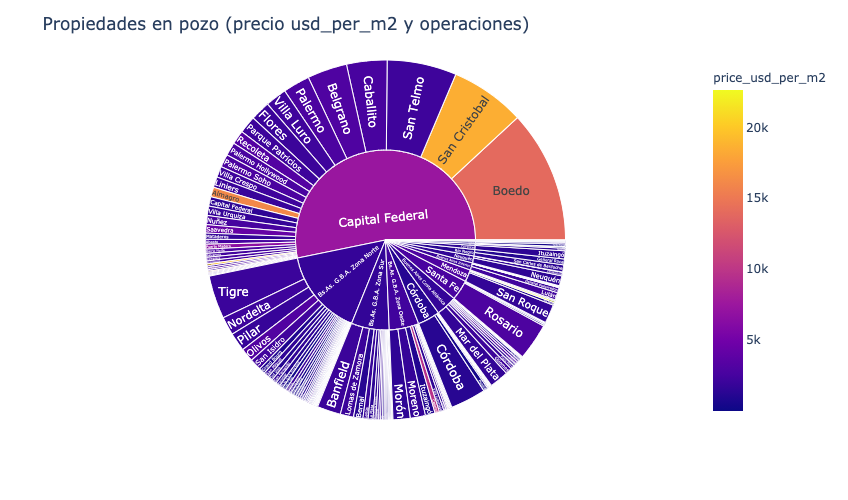

In [97]:
#Detalle en pozo
fig = px.sunburst(df_grouped_antig[df_grouped_antig.antigüedad=='En Pozo'].dropna(subset=['price_usd_per_m2']), 
                  path=['state_name','place_name'], values='operation',
                  color='price_usd_per_m2')

fig.update_layout(
    title='Propiedades en pozo (precio usd_per_m2 y operaciones)', autosize=False, width=700, height=500,)

fig.show()

Se identifican posibles outliers en Boedo, San Cristobal y Almagro, con valores de precio/m2 demasiado elevados

In [98]:
#Revisar samples de qué dicen en descripción los casos de pozo de Boedo
data[mask_p].loc[data.place_name=='Boedo']['description'].sample(5).unique()
#Se identifican casos que asos con cuotas

array(['Deptos a estrenar de pozo Edificio con PiscinaDEPA TODO DESDE  u$s 40.000.-SOLO PARA INVERSORESEN EL CORAZON DE BOEDOGRAN PRE LANZAMIENTO UNIDADES PRE-VENTA  DEPTO  PARA INVERTIRESTA ES LA FORMA DE TENER TU DEPANUEVO PROYECTOConsulta otros planes en 48 cuotas En Pesos en cuotas de $ 7.500.-PRE VENTA DE POZOEl barrio de Boedo limita al Norte con Almagro; al Este con San Cristobal y Parque Patricios; al Sur Nueva Pompeya y al Oeste con Pque. Chacabuco y Caballito.El edificio est ubicado a 80 mts de Av. Independencia,  a 220 mts de Av. San Juan; zona comercial y turstico, proximo a  Supermercados, prximo a la tradicional esquina conocida como "Esquina Homero Manzi", al caf ?Trianon?, la plaza Mariano Boedo, corazn de los primeros teatros independientes, cercano a Bancos, Colegios, con numerosos medios de transporte como ser el subte "E" estacin Boedo, numerosas lneas de transporte.Proximo Centro-Subte-Plaza-Colegios-TeatrosLaundry ? Sum ? Solarium ? Parrilla ? PISCINAConsultanos:T

<a id="Cuotas"></a>
#### Cuotas

In [189]:
#Sacar Cuotas de description
pattern_cuota = 'cuotas|cuotitas'
#mascara antigüedad
mask_cuota = search_extract(pattern_cuota, col=data['description'])

mask_cuota.value_counts()


False    111716
True       9504
Name: description, dtype: int64

In [190]:
#Agregar columna con cuotas al data frame
cuota = mask_cuota.apply(lambda x: 1 if x ==True else 0)
data['cuota']=cuota

Relación precio y m2 total en función de cuotas


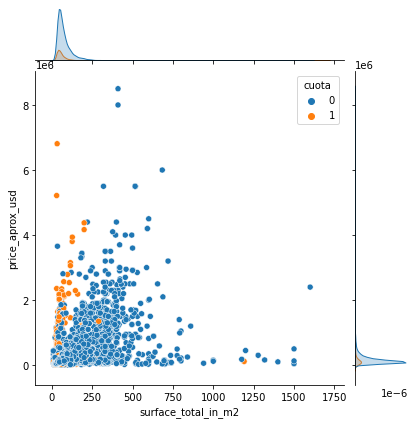

In [195]:
data_selection_1 = data.loc[data.surface_total_in_m2 <2000].loc[data.surface_covered_in_m2<2000].loc[data.property_type=='apartment']

print('Relación precio y m2 total en función de cuotas')
sns.jointplot(data =data_selection_1, y= 'price_aprox_usd', x='surface_total_in_m2', hue='cuota');

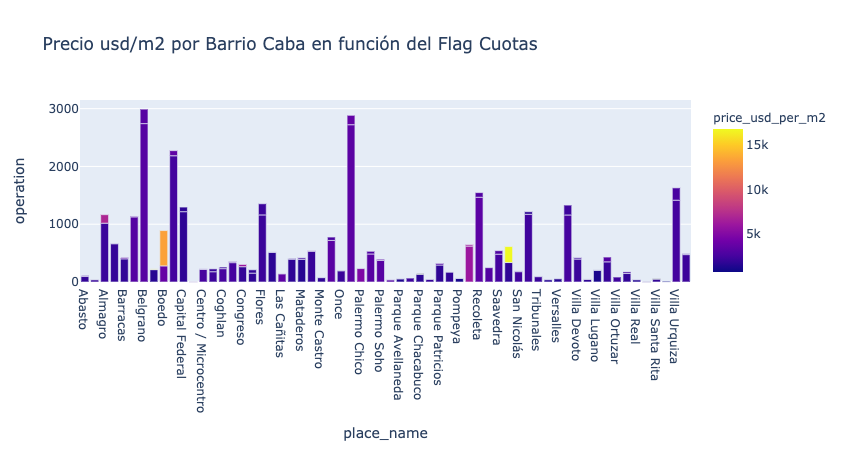

In [102]:
df_grouped_cuota=data.groupby(['state_name','place_name','cuota']).agg(
    {'operation':'count','price_usd_per_m2':'mean'}).reset_index()
fig = px.bar(df_grouped_cuota[df_grouped_cuota.state_name=='Capital Federal'], 
             x="place_name", y="operation", color="price_usd_per_m2", 
             title="Precio usd/m2 por Barrio Caba en función del Flag Cuotas", hover_data=['cuota'])
fig.show()

<a id="Credito"></a>
#### Apto Crédito

In [197]:
#Sacar Apto crédito de description
pattern_ac = 'apto credito|apto crédito'
mask_ac = search_extract(pattern_ac, col=data['description'])
print(mask_ac.sum(), mask_ac.shape)


9811 (121220,)


In [198]:
#Agregar al dataset
credito = mask_ac.apply(lambda x: 1 if x ==True else 0)
print(credito.shape)
data['credito']=credito

(121220,)


Relación precio y m2 total  (abierto por flag credito)


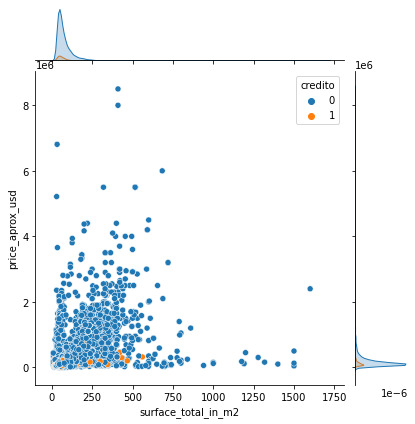

In [208]:
#Graficar
print('Relación precio y m2 total  (abierto por flag credito)')
data_selection_2 = data.loc[data.surface_total_in_m2 <2000].loc[data.surface_covered_in_m2<2000].loc[data.property_type=='apartment']
sns.jointplot(data =data_selection_2, y= 'price_aprox_usd', x='surface_total_in_m2', hue='credito')


In [106]:
#Revisar valores por state
data.pivot_table(values='price_usd_per_m2', index=['state_name'] ,columns='credito', aggfunc=['mean','median','std','count']).head(10)

mean                    median  \
credito                                 0            1            0   
Bs.As. G.B.A. Zona Norte      1870.435964  1708.681028  1666.666667   
Bs.As. G.B.A. Zona Oeste      1341.779040  1409.464242  1243.090548   
Bs.As. G.B.A. Zona Sur        1525.019315  1529.378947  1484.375000   
Buenos Aires Costa Atlántica  1588.037289  1477.352699  1625.000000   
Buenos Aires Interior          949.702231  1128.346979   850.000000   
Capital Federal               3200.338173  2311.085800  2500.000000   
Catamarca                      556.045469          NaN   376.138108   
Chaco                          939.802732          NaN   852.589356   
Chubut                        1703.276620  1836.713411  1452.183081   
Corrientes                    1503.804096  1101.406012  1500.000000   

                                                   std                count  \
credito                                 1            0           1        0   
Bs.As. G.B.A. Zona Norte      1634.615385  1943.717165  758.160463  16366.0   
Bs.As. G.B.A. Zona Oeste      1416.666667  1722.454750  745.606946   4068.0   
Bs.As. G.B.A. Zona Sur        1513.389711  1141.506133  813.742027   5695.0   
Buenos Aires Costa Atlántica  1577.777778   947.298514  639.387641   5581.0   
Buenos Aires Interior         1101.948052   710.598969  634.921690    953.0   
Capital Federal               2285.714286  3850.881226  688.603461  21236.0   
Catamarca                             NaN   562.821671         NaN      6.0   
Chaco                                 NaN   574.032766         NaN     28.0   
Chubut                        1800.000000  1528.563337  319.327844    120.0   
Corrientes                    1046.025105   612.857984  555.773390    306.0   

                                      
credito                            1  
Bs.As. G.B.A. Zona Norte      1039.0  
Bs.As. G.B.A. Zona Oeste       555.0  
Bs.As. G.B.A. Zona Sur         478.0  
Buenos Aires Costa Atlántica   769.0  
Buenos Aires Interior           58.0  
Capital Federal               2198.0  
Catamarca                        0.0  
Chaco                            0.0  
Chubut                           5.0  
Corrientes                       9.0

In [107]:
#Revisar valores cap federal
data[data.state_name=='Capital Federal'].pivot_table(values='price_usd_per_m2', index=['place_name'] ,columns='credito', aggfunc=['mean','median','std','count']).head(10)

mean                    median               \
credito                  0            1            0            1   
Abasto         2060.713909  2006.572962  2093.693694  2321.428571   
Agronomía      2096.782364  2024.630451  2151.442308  2317.073171   
Almagro        2849.060864  2179.984857  2151.923077  2178.197227   
Balvanera      1986.602219  1961.183848  1855.537721  1896.666667   
Barracas       1964.386139  2105.390284  1826.000000  2214.323708   
Barrio Norte   3131.898228  2715.954617  2871.146245  2614.743590   
Belgrano       3187.387693  2779.031596  3011.580000  2767.867272   
Boca           2103.816161  1469.279993  1711.181094  1533.030303   
Boedo         11000.984405  1663.404441  8145.333333  1755.555556   
Caballito      2483.715542  2321.691820  2421.052632  2236.842105   

                       std             count       
credito                  0           1     0    1  
Abasto          559.609205  443.274629    80    5  
Agronomía       465.638667  563.527081    22    3  
Almagro        3523.670692  428.567920   706  124  
Balvanera       990.920094  389.712464   392   81  
Barracas       1638.676215  495.641992   341   14  
Barrio Norte   1205.545998  698.480513   818   72  
Belgrano       1148.938854  408.259252  1953  174  
Boca           3130.935773  484.740068   168   10  
Boedo         13302.342285  376.583742   774   26  
Caballito      1019.687308  542.063004  1512  166

<a id="Cochera"></a>
#### Cochera

In [200]:
#Sacar Con cochera de description
pattern_cochera = 'con cochera'
mask_cochera = search_extract(pattern_cochera, col=data['description'])
mask_cochera.sum()
#5752 registros, son pocos

5752

In [201]:
#Verificar valor particular
data[mask_cochera]['description'].iloc[0]

'ULTIMA UNIDAD DISPONIBLEHAUS BOULEVARD: Metros Cubiertos: 115,23m²Contado U$D250.000HAUS VILLAGE es un complejo residencial de 20 casas con cochera y jardín propio, dentro del Barrio Cerrado Buenos Aires Village.Todas las unidades tienen entrada para auto, en planta baja cuentan con un toilette, living comedor con cocina separada.Patio exclusivo y, en planta alta, 3 dormitorios con espacio para placard (uno en suite).Realizados en una estructura monolítica de Hormigón Armado sobre platea de fundación y aberturas de PVC con DVH. La calidad de la construcción conjuga lo moderno y lo funcional, con un cuidado especial por lo estético. Son amplias superficies vidriadas que permiten vivir el verde del jardín en todo momento. El barrio cerrado cuenta con una doble entrada, lo que permite una mejor circulación interna de vehículos. Ofrece excelentes alternativas para los accesos al barrio, una entrada es por la autopista del Buen Ayre y la otra por la calle Flaubert. EasyBroker ID: EB-AN8955

In [202]:
#Agregar cochera al dataset
cochera = mask_cochera.apply(lambda x: 1 if x ==True else 0)
data['cochera']=cochera


Relaciprecio y m2 total en función de cochera en barrio Belgrano


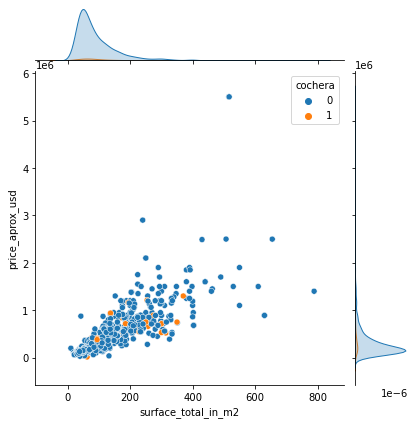

In [203]:
#Graficar ejemplo en Belgrano
print('Relación precio y m2 total en barrio Belgrano (abierto por flag cochera)')

data_selection_3 = data.loc[data['place_name']=='Belgrano'].loc[data.surface_total_in_m2 <2000].loc[data.surface_covered_in_m2<2000].loc[data.property_type=='apartment']

sns.jointplot(data =data_selection_3, y= 'price_aprox_usd', x='surface_total_in_m2', hue='cochera');


In [112]:
#Revisar valores por state
data.pivot_table(values='price_usd_per_m2', index=['state_name'] ,columns='cochera', aggfunc=['mean','median','std','count']).head(50)

mean                    median  \
cochera                                 0            1            0   
Bs.As. G.B.A. Zona Norte      1838.899727  2290.649218  1644.444444   
Bs.As. G.B.A. Zona Oeste      1337.092362  1603.902276  1250.000000   
Bs.As. G.B.A. Zona Sur        1499.010479  1901.575951  1459.459459   
Buenos Aires Costa Atlántica  1544.038418  2059.360375  1595.161290   
Buenos Aires Interior          943.849701  1569.938278   850.000000   
Capital Federal               3122.798287  2988.906347  2450.000000   
Catamarca                      556.045469          NaN   376.138108   
Chaco                          922.789268  1160.977771   852.589356   
Chubut                        1708.614091          NaN  1500.000000   
Corrientes                    1490.210560  1563.586262  1500.000000   
Córdoba                       1214.089340  1356.402575  1218.067344   
Entre Ríos                    1244.082801  2188.953488   862.825692   
Formosa                       1509.648462          NaN  1513.742424   
Jujuy                          617.077447          NaN   287.742900   
La Pampa                       899.381177          NaN   855.936328   
La Rioja                       243.029233          NaN   243.029233   
Mendoza                       1653.059731  4532.852748  1446.153846   
Misiones                       745.686759  1219.565368   562.854137   
Neuquén                       1800.013640  1482.406110  1818.930000   
Río Negro                     1840.908283  3052.962855  1485.294118   
Salta                         2547.463501          NaN  1078.532212   
San Juan                      1648.244241          NaN  1648.244241   
San Luis                      1646.549500   586.529975   989.583333   
Santa Cruz                     697.388256          NaN   552.339205   
Santa Fe                      2190.656066  1838.954373  1590.909091   
Santiago Del Estero            269.769379          NaN   224.000000   
Tierra Del Fuego              1168.748152          NaN   917.419400   
Tucumán                       1336.854517  1412.025746   785.171452   

                                                   std                 count  \
cochera                                 1            0            1        0   
Bs.As. G.B.A. Zona Norte      2129.629630  1905.803939  1592.385780  16562.0   
Bs.As. G.B.A. Zona Oeste      1621.621622  1664.819715   867.225091   4401.0   
Bs.As. G.B.A. Zona Sur        1815.953654  1121.697978  1017.018474   5769.0   
Buenos Aires Costa Atlántica  2152.777778   914.650059   797.845802   5973.0   
Buenos Aires Interior         1574.588467   692.748301   965.087830    985.0   
Capital Federal               2822.240741  3756.845758  1109.640249  22407.0   
Catamarca                             NaN   562.821671          NaN      6.0   
Chaco                         1160.977771   569.748891   822.289485     26.0   
Chubut                                NaN  1498.756329          NaN    125.0   
Corrientes                    1461.538462   616.160013   570.297531    306.0   
Córdoba                       1352.941176   869.079736   563.745211   3531.0   
Entre Ríos                    2188.953488  2653.888554          NaN     81.0   
Formosa                               NaN     8.883072          NaN     29.0   
Jujuy                                 NaN   711.251908          NaN      4.0   
La Pampa                              NaN   335.627014          NaN     10.0   
La Rioja                              NaN          NaN          NaN      1.0   
Mendoza                       1028.200650  2504.094523  7543.158119    310.0   
Misiones                      1740.527759   649.425367   902.333329    190.0   
Neuquén                       1335.325595  1425.373872   736.118753    231.0   
Río Negro                     3300.000000  1571.033032   701.767915    200.0   
Salta                                 NaN  4953.591438          NaN     63.0   
San Juan                              NaN  2182.478180          Na

In [113]:
#Comparación con y sin cochera Cap Federal
data[data.state_name=='Capital Federal'].pivot_table(values='price_usd_per_m2', aggfunc=['mean','median','std','count'], columns='cochera', index=['state_name','place_name'], margins=True).head(63)

mean                            \
cochera                                     0            1          All   
state_name      place_name                                                
All                               3122.798287  2988.906347  3116.930444   
Capital Federal Abasto            2057.529147          NaN  2057.529147   
                Agronomía         2070.962640  2500.000000  2088.124134   
                Almagro           2755.386838  2581.520733  2749.102521   
                Balvanera         1980.229232  2171.336207  1982.249390   
...                                       ...          ...          ...   
                Villa Riachuelo   1110.690766          NaN  1110.690766   
                Villa Santa Rita  1875.058392  2065.789474  1889.186620   
                Villa Soldati      743.666758          NaN   743.666758   
                Villa Urquiza     2488.039150  2690.270863  2495.288265   
                Villa del Parque  2236.937725  2174.029627  2233.837905   

                                       median                            \
cochera                                     0            1          All   
state_name      place_name                                                
All                               2450.000000  2822.240741  2468.750000   
Capital Federal Abasto            2133.333333          NaN  2133.333333   
                Agronomía         2151.442308  2500.000000  2187.500000   
                Almagro           2142.857143  2718.494272  2162.602820   
                Balvanera         1863.391376  2152.777778  1865.671642   
...                                       ...          ...          ...   
                Villa Riachuelo   1229.508197          NaN  1229.508197   
                Villa Santa Rita  2067.567568  2065.789474  2067.567568   
                Villa Soldati      775.688994          NaN   775.688994   
                Villa Urquiza     2500.000000  2666.666667  2502.976190   
                Villa del Parque  2224.972191  2022.471910  2224.137931   

                                          std                            \
cochera                                     0            1          All   
state_name      place_name                                                
All                               3756.845758  1109.640249  3681.030087   
Capital Federal Abasto             551.400794          NaN   551.400794   
                Agronomía          467.433591          NaN   465.567568   
                Almagro           3321.900760   431.901397  3262.402046   
                Balvanera          919.496191   526.426798   916.104947   
...                                       ...          ...          ...   
                Villa Riachuelo    300.235095          NaN   300.235095   
                Villa Santa Rita   435.915298   130.256512   422.668519   
                Villa Soldati      517.429433          NaN   517.429433   
                Villa Urquiza      708.401047   626.531701   706.374193   
                Villa del Parque   647.785699   882.605335   659.778064   

                                    count                 
cochera                                 0       1    All  
state_name      place_name                                
All                               22407.0  1027.0  23434  
Capital Federal Abasto               85.0     NaN     85  
                Agronomía            24.0     1.0     25  
                Almagro             800.0    30.0    830  
                Balvanera           468.0     5.0    473  
...                                   ...     ...    ...  
                Villa Riachuelo       3.0     NaN      3  
                Villa Santa Rita     25.0     2.0     27  
                Villa Soldati         7.0     NaN      7  
                Villa Urquiza      1049.0    39.0   1088  
                Villa del Parque    328.0    17.0    345  

[63 rows x 12 columns]

<a id="Seguridad"></a>
## Seguridad

In [204]:
#Sacar Seguridad de description
pattern_seg = 'seguridad'
mask_seg=search_extract(pattern_seg,col=data['description'])
mask_seg.sum()

11366

In [205]:
seguridad = mask_seg.apply(lambda x: 1 if x ==True else 0)
data['seguridad']=seguridad

Relación precio y m2 total en barrio Belgrano (abierto por flag seguridad)


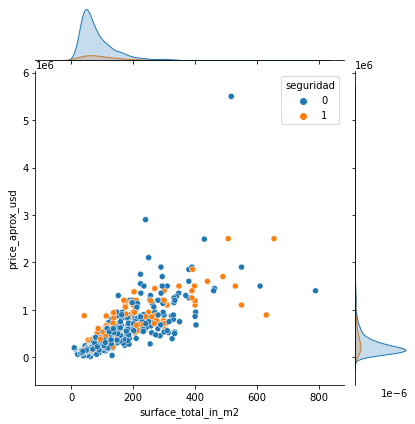

In [207]:
##Graficar ejemplo Belgrano
print('Relación precio y m2 total en barrio Belgrano (abierto por flag seguridad)')

data_selection_4 = data.loc[data.surface_total_in_m2 <2000].loc[data.surface_covered_in_m2<2000].loc[data.property_type=='apartment']

sns.jointplot(data=data_selection_4[data_selection_4.place_name=='Belgrano'], y='price_aprox_usd', x='surface_total_in_m2', hue='seguridad');

Precio promedio por número de ambientes en barrio Belgrano (abierto por flag seguridad)


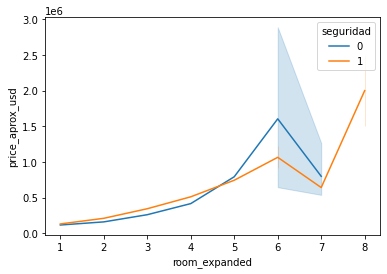

In [209]:
#Graficar ejemplo Belgrano
print('Precio promedio por número de ambientes en barrio Belgrano (abierto por flag seguridad)')

sns.lineplot(data=data_selection_4[data_selection_4.place_name=='Belgrano'], y='price_aprox_usd', x='room_expanded', hue='seguridad');

<a id="Amenities"></a>
### Amenities

In [210]:
pattern_amenities = '(ammenities|amenities)'
mask_amenities = search_extract(pattern_amenities, col=data['description'])
mask_amenities.sum()

11039

In [211]:
amenities = mask_amenities.apply(lambda x: 1 if x ==True else 0)
data['amenities']=amenities

Relación precio y m2 total en barrio Palermo (abierto por flag amenities)


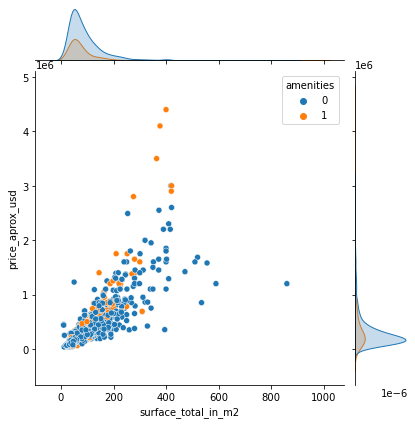

In [213]:
print('Relación precio y m2 total en barrio Palermo (abierto por flag amenities)')

data_selection_5 = data.loc[data.surface_total_in_m2 <2000].loc[data.surface_covered_in_m2<2000].loc[data.property_type=='apartment']

sns.jointplot(data=data_selection_5[data_selection_5.place_name=='Palermo'], y='price_aprox_usd', x='surface_total_in_m2', hue='amenities');

Precio promedio por número de ambientes en barrio Palermo (abierto por flag amenities)


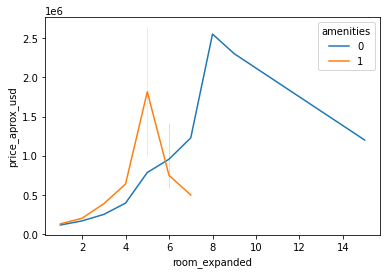

In [214]:
print('Precio promedio por número de ambientes en barrio Palermo (abierto por flag amenities)')

sns.lineplot(data=data_selection_5[data_selection_5.place_name=='Palermo'], y='price_aprox_usd', x='room_expanded', hue='amenities');

<a id="barrios"></a>
## Barrios Cerrados
[volver al indice](#indice)

Extracciones datos
1. Buscar en place_name
2. Buscar en description
3. Buscar en description pattern_barrio
4. Buscar en description Golf, Club House

Agregar al data set
1. columna boolean es_barrio_cerrado
2. columna string state name + 'barrio_cerrado'

### Extracciones de datos

In [122]:
#Generar Patron para countries
pattern_bc_title='Country|Club|Nordelta|Altos del|Estancias|Haras|(Barrio)(?! Norte)(?! Parque)'
mask_bc_place = search_extract(pattern_bc_title, col=data['place_name'])
mask_bc_place.sum()

5593

In [123]:
#Chequear tipos de valores
data[mask_bc_place][['place_name','state_name']].value_counts()

place_name                    state_name              
Nordelta                      Bs.As. G.B.A. Zona Norte    3315
Los Pingüinos Country Club    Bs.As. G.B.A. Zona Oeste     317
Barrio Los Alisos             Bs.As. G.B.A. Zona Norte     278
Haras Santa Maria             Bs.As. G.B.A. Zona Norte     126
Santa Barbara Barrio Cerrado  Bs.As. G.B.A. Zona Norte      93
                                                          ... 
Barrio Cerrado "La Emilia"    Bs.As. G.B.A. Zona Norte       1
Barrio Cerrado "La Damasia"   Bs.As. G.B.A. Zona Norte       1
Barrio Cerrado "La Chacra"    Bs.As. G.B.A. Zona Norte       1
El Canton Barrio Islas        Bs.As. G.B.A. Zona Norte       1
Barrio Privado El Resuello    Bs.As. G.B.A. Zona Oeste       1
Length: 165, dtype: int64

In [124]:
#Revisar tipos de valores que quedan
data[mask_bc_place][['place_name','description']]


place_name  \
17                 Barrio El Golf   
26             Barrio San Gabriel   
27            Estancias del Pilar   
33                 Barrio El Golf   
104                      Nordelta   
...                           ...   
120237  El Nacional Club de Campo   
120311                   Nordelta   
120313                   Nordelta   
120962                   Nordelta   
121066                   Nordelta   

                                              description  
17      Excelente 3 ambientes en un 6 piso y con terra...  
26      Casa en venta en complejo Villanueva barrio Sa...  
27      Estancias propone vivir rodeados de naturaleza...  
33      Excelente 3 ambientes en un 6 piso en esquina ...  
104     Nordelta - LOS SAUCES -Excelente casa en dos p...  
...                                                   ...  
120237  Venta de Casa en Barrio Privado El Nacional, G...  
120311  A estrenar. Dos ambientes y medio o dos ambien...  
120313  Hall de entrada. Espacio amplio para placard d...  
120962  Hermosa Casa sobre gran lote en esquina muy lu...  
121066  Preciosa casa en Barrio Los Alisos NordeltaSob...  

[5593 rows x 2 columns]

In [125]:
#Pattern countries para usar en descripcion
pattern_bc_desc = 'Country|Barrio Cerrado|Club de|Haras|Altos del|Estancia|Ayres'
mask_bc_desc = search_extract(pattern_bc_desc, col=data['description'])
mask_bc_desc.sum()

3441

In [126]:
pattern_barrio = '(Barrio)(?! Norte)(?! Parque)(?! de)(?P<nombre> San \w+| Los \w+| La \w+)'
values_barrio, mask_barrio = search_extract(pattern_barrio, 'nombre', col=data['description'])
mask_barrio.sum()

1658

In [127]:
#chequear los valores devueltos
values_barrio.sample(40).unique()

array([' los castores', ' san gabriel', ' san rafael', ' la reserva',
       ' los castaños', ' los alisos', ' los cielos', ' los troncos',
       ' san francisco', ' san matías', ' la calabria', ' la quinta',
       ' la estancia', ' los lagos', ' san marco', ' los robles',
       ' san agustin', ' san carlos', ' los omos', ' san isidro',
       ' san sebastián', ' la isla', ' san vicente', ' los ceibos',
       ' san lucas', ' la comarca'], dtype=object)

In [128]:
#Extraer atributos en 'description'
pattern_golf ='(Golf|Club House)'

mask_golf = search_extract(pattern_golf, col=data['description'])
mask_golf.sum()

3648

In [129]:
#Combinar las 3 mascaras
#chequear que mascaras tengan el mismo tamaños
mask_barrio_cerrado = mask_bc_place | mask_bc_desc | mask_barrio | mask_golf
#Resultado
print('Num countries: ', mask_barrio_cerrado.sum(),'Shape mask:', mask_barrio_cerrado.shape)



Num countries:  11231 Shape mask: (121220,)


### Agregar al dataset

In [130]:
#Agregar a data
es_barrio_cerrado=mask_barrio_cerrado.apply(lambda x: 1 if x==True else 0)
print(es_barrio_cerrado.sum(), es_barrio_cerrado.shape)

data['es_barrio_cerrado']= es_barrio_cerrado

11231 (121220,)


In [131]:
#Actualizar la columna con zona + flag barrio cerrado
zona_barrio_cerrado = data.loc[mask_barrio_cerrado]['state_name'].apply(lambda x: x+'_barrio_cerrado')
data.loc[mask_barrio_cerrado, 'zona_barrio_cerrado']=zona_barrio_cerrado
data['zona_barrio_cerrado'].value_counts()

Bs.As. G.B.A. Zona Norte_barrio_cerrado        7687
Córdoba_barrio_cerrado                          706
Bs.As. G.B.A. Zona Oeste_barrio_cerrado         690
Bs.As. G.B.A. Zona Sur_barrio_cerrado           626
Capital Federal_barrio_cerrado                  415
Buenos Aires Costa Atlántica_barrio_cerrado     398
Santa Fe_barrio_cerrado                         246
Buenos Aires Interior_barrio_cerrado            149
Río Negro_barrio_cerrado                         91
Neuquén_barrio_cerrado                           60
Mendoza_barrio_cerrado                           39
Corrientes_barrio_cerrado                        37
Tucumán_barrio_cerrado                           24
San Luis_barrio_cerrado                          19
Salta_barrio_cerrado                             16
Chubut_barrio_cerrado                             9
Misiones_barrio_cerrado                           9
Entre Ríos_barrio_cerrado                         5
Jujuy_barrio_cerrado                              3
Santa Cruz_b

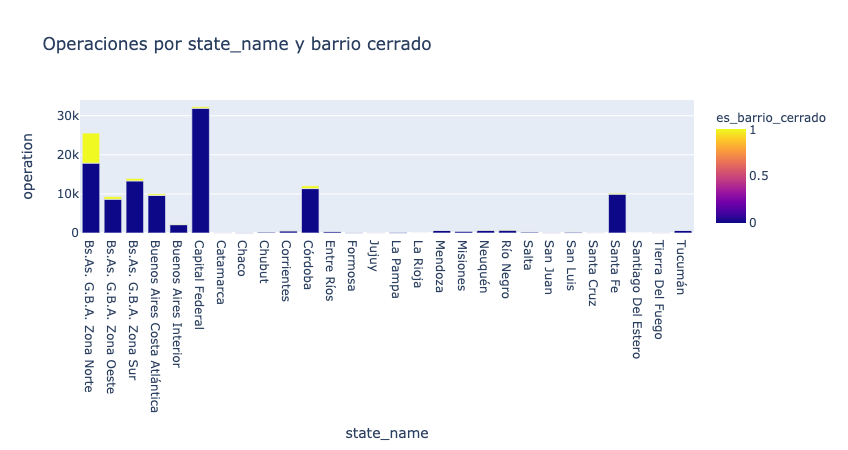

In [132]:
grouped_bc=data.groupby(['state_name','es_barrio_cerrado']).aggregate({'operation':'count'}).reset_index()
px.bar(grouped_bc, x='state_name', y='operation',color='es_barrio_cerrado', title="Operaciones por state_name y barrio cerrado")

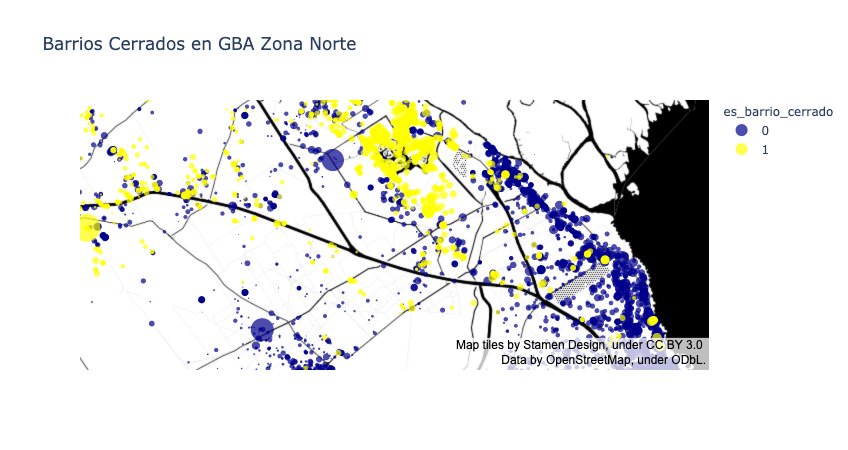

In [133]:
data_gban=data.loc[data.state_name=='Bs.As. G.B.A. Zona Norte'].dropna(subset=['lat','lon','price_usd_per_m2'])
data_gban['es_barrio_cerrado']=data_gban['es_barrio_cerrado'].astype(str)
fig = px.scatter_mapbox(data_gban,
                        title='Barrios Cerrados en GBA Zona Norte',
                        lat="lat", lon="lon", color="es_barrio_cerrado", size="price_usd_per_m2",
                        size_max=20, zoom=10,
                        mapbox_style="stamen-toner", hover_name="place_name", 
                        hover_data= ["title",'place_name'],
                       color_discrete_sequence=['DarkBlue','Yellow'])

fig.show()

In [134]:
#volver a chequear valores
data.pivot_table(values='price_usd_per_m2', aggfunc=['mean','median','std','count'], columns='es_barrio_cerrado', index=['state_name'], margins=True)

mean                            \
es_barrio_cerrado                       0            1          All   
Bs.As. G.B.A. Zona Norte      1837.634264  1912.680875  1860.779924   
Bs.As. G.B.A. Zona Oeste      1355.492803  1230.087764  1349.904779   
Bs.As. G.B.A. Zona Sur        1521.696221  1591.226576  1525.356899   
Buenos Aires Costa Atlántica  1576.519968  1529.533844  1574.633123   
Buenos Aires Interior          971.596806   753.559393   959.950891   
Capital Federal               3114.104006  3331.267143  3116.930444   
Catamarca                      556.045469          NaN   556.045469   
Chaco                          965.708071   240.358595   939.802732   
Chubut                        1688.656799  2312.322181  1708.614091   
Corrientes                    1478.983932  1688.822375  1492.307008   
Córdoba                       1235.116185   977.641808  1219.628477   
Entre Ríos                    1255.605614          NaN  1255.605614   
Formosa                       1509.648462          NaN  1509.648462   
Jujuy                          617.077447          NaN   617.077447   
La Pampa                       899.381177          NaN   899.381177   
La Rioja                       243.029233          NaN   243.029233   
Mendoza                       1638.654970  2529.892023  1689.744992   
Misiones                       755.303637   610.496463   753.052748   
Neuquén                       1776.520192  1908.899221  1788.103357   
Río Negro                     1732.568545  3391.523036  1925.470230   
Salta                         2625.905500  1390.444008  2547.463501   
San Juan                      1648.244241          NaN  1648.244241   
San Luis                      1689.674435   462.851112  1600.125287   
Santa Cruz                     697.388256          NaN   697.388256   
Santa Fe                      2161.016618  2977.670547  2178.133354   
Santiago Del Estero            269.769379          NaN   269.769379   
Tierra Del Fuego              1168.748152          NaN  1168.748152   
Tucumán                       1359.217920   890.831548  1338.515760   
All                           2189.120277  1901.689584  2160.086916   

                                   median                            \
es_barrio_cerrado                       0            1          All   
Bs.As. G.B.A. Zona Norte      1612.809440  1778.091787  1666.666667   
Bs.As. G.B.A. Zona Oeste      1260.000000  1254.629630  1260.000000   
Bs.As. G.B.A. Zona Sur        1491.447368  1524.390244  1492.063492   
Buenos Aires Costa Atlántica  1625.000000  1375.000000  1617.647059   
Buenos Aires Interior          873.015873   392.710219   866.666667   
Capital Federal               2460.711111  2870.370370  2468.750000   
Catamarca                      376.138108          NaN   376.138108   
Chaco                          858.781250   240.358595   852.589356   
Chubut                        1465.517241  2876.447635  1500.000000   
Corrientes                    1461.538462  1707.142857  1500.000000   
Córdoba                       1246.303778   976.941419  1223.601326   
Entre Ríos                     864.105154          NaN   864.105154   
Formosa                       1513.742424          NaN  1513.742424   
Jujuy                          287.742900          NaN   287.742900   
La Pampa                       855.936328          NaN   855.936328   
La Rioja                       243.029233          NaN   243.029233   
Mendoza                       1466.744186  1239.602662  1435.439560   
Misiones                       562.854137   726.329574   564.871547   
Neuquén                       1854.379597   764.777386  1815.715000   
Río Negro                     1443.153017  3974.511364  1600.000000   
Salta                         1078.532212  1491.154135  1078.532212   
San Juan                      1648.244241          NaN  1648.244241   
San Luis                      1009.463722   376.351541   934.959350   
Santa Cruz                     552.339205          NaN   552

In [135]:
#chequear zona norte no country
data.loc[data.state_name=='Bs.As. G.B.A. Zona Norte'].loc[data.zona_barrio_cerrado.isnull()]['place_name'].value_counts()

#Siguen quedando bastantes valores

Tigre                         2584
Pilar                         1631
Olivos                        1546
Martínez                      1039
San Isidro                     918
                              ... 
San Miguel de Ghiso              1
Vila Vela Terrazas al Lago       1
La Herradura                     1
Los Tres Coniles                 1
La Arboleda de Maschwitz         1
Name: place_name, Length: 131, dtype: int64

In [136]:
data.loc[data.state_name=='Bs.As. G.B.A. Zona Norte'].loc[data.zona_barrio_cerrado.isnull()]['place_name'].unique()


array(['Munro', 'San Miguel', 'Martínez', 'Pilar', 'Del Viso',
       'San Isidro', 'Acassuso', 'San Martín', 'Victoria', 'Benavidez',
       'Beccar', 'Jose Leon Suarez', 'Olivos', 'El Talar', 'Villa Maipu',
       'San Andres', 'Belén de Escobar', 'José C Paz', 'San Fernando',
       'Virreyes', 'Villa Ballester', 'General San Martín', 'Tigre',
       'Vicente López', 'La Lonja', 'Villa de Mayo', 'Manuel Alberti',
       'Rincón de Milberg', 'QBay Yacht', 'La Lucila', 'Islas del Canal',
       'Ricardo Rojas', 'Bella Vista', 'Garín', 'Delta',
       'Boulogne Sur Mer', 'Villa Adelina', 'Villa Libertad', 'Muñiz',
       'Escobar', 'La Peregrina', 'Florida', 'Bs.As. G.B.A. Zona Norte',
       'Boca Ratón', 'Malvinas Argentinas', 'Tortuguitas',
       'Los Polvorines', 'Solares del Talar', 'Derqui', 'Don Torcuato',
       'Grand Bourg', 'Villa Bonich', 'Barrio Parque General San Martin',
       'Florida Oeste', 'Villa Martelli', 'Laguna del Sol', 'Villa Rosa',
       'Carapachay', 'Masc

In [137]:
#Porcentaje de barrios cerrados por state
barrio_cerrado_by_state = data.groupby('state_name')['es_barrio_cerrado'].sum()
total_by_state = data.groupby('state_name')['operation'].count()
print(barrio_cerrado_by_state.shape, total_by_state.shape)
barrio_cerrado_by_state/ total_by_state

(28,) (28,)


state_name
Bs.As. G.B.A. Zona Norte        0.300743
Bs.As. G.B.A. Zona Oeste        0.074018
Bs.As. G.B.A. Zona Sur          0.044868
Buenos Aires Costa Atlántica    0.039776
Buenos Aires Interior           0.065037
Capital Federal                 0.012842
Catamarca                       0.000000
Chaco                           0.017544
Chubut                          0.034749
Corrientes                      0.063465
Córdoba                         0.058497
Entre Ríos                      0.013550
Formosa                         0.000000
Jujuy                           0.115385
La Pampa                        0.000000
La Rioja                        0.000000
Mendoza                         0.057269
Misiones                        0.019397
Neuquén                         0.081855
Río Negro                       0.112624
Salta                           0.057554
San Juan                        0.000000
San Luis                        0.075397
Santa Cruz                      0.050000
Santa

## Resumen final

In [138]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121220 entries, 0 to 121219
Data columns (total 42 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Unnamed: 0                  121220 non-null  int64  
 1   operation                   121220 non-null  object 
 2   property_type               121220 non-null  object 
 3   place_name                  121197 non-null  object 
 4   place_with_parent_names     121220 non-null  object 
 5   country_name                121220 non-null  object 
 6   state_name                  121220 non-null  object 
 7   geonames_id                 102503 non-null  float64
 8   lat-lon                     69670 non-null   object 
 9   lat                         69670 non-null   float64
 10  lon                         69670 non-null   float64
 11  price                       100810 non-null  float64
 12  currency                    100809 non-null  object 
 13  price_aprox_lo

In [139]:
data.describe()

Unnamed: 0   geonames_id           lat           lon         price  \
count  121220.000000  1.025030e+05  69670.000000  69670.000000  1.008100e+05   
mean    60609.500000  3.574442e+06    -34.626210    -59.266290  4.685259e+05   
std     34993.344153  3.541306e+05      1.980936      2.299922  2.260101e+06   
min         0.000000  3.427208e+06    -54.823985    -75.678931  0.000000e+00   
25%     30304.750000  3.430234e+06    -34.669065    -58.727040  1.100000e+05   
50%     60609.500000  3.433910e+06    -34.597985    -58.480128  1.850000e+05   
75%     90914.250000  3.836668e+06    -34.441299    -58.395908  4.200000e+05   
max    121219.000000  6.948895e+06      4.545843    -53.733330  6.500000e+08   

       price_aprox_local_currency  price_aprox_usd  surface_total_in_m2  \
count                1.008100e+05     1.008100e+05         81892.000000   
mean                 4.229397e+06     2.397006e+05           233.795328   
std                  6.904714e+06     3.913239e+05          1782.222147   
min                  0.000000e+00     0.000000e+00             0.000000   
25%                  1.583309e+06     8.973388e+04            50.000000   
50%                  2.558452e+06     1.450000e+05            84.000000   
75%                  4.675792e+06     2.650000e+05           200.000000   
max                  8.212711e+08     4.654544e+07        200000.000000   

       surface_covered_in_m2  price_usd_per_m2  ...  room_expanded  \
count          101313.000000      68617.000000  ...   71664.000000   
mean              133.050181       2160.086916  ...       2.921048   
std               724.351479       2759.288621  ...       1.686655   
min                 0.000000          0.600000  ...       1.000000   
25%                45.000000       1218.181818  ...       2.000000   
50%                75.000000       1800.000000  ...       3.000000   
75%               150.000000       2486.411765  ...       4.000000   
max            187000.000000     206333.333333  ...      32.000000   

               dorm  room_expanded_2    room_fixed          cuota  \
count  37263.000000     78284.000000  78039.000000  121220.000000   
mean       2.333736         2.919473      2.977716       0.078403   
std        0.942580         1.631121      1.625241       0.268806   
min        1.000000         1.000000      1.000000       0.000000   
25%        2.000000         2.000000      2.000000       0.000000   
50%        2.000000         3.000000      3.000000       0.000000   
75%        3.000000         4.000000      4.000000       0.000000   
max        9.000000        32.000000     32.000000       1.000000   

             credito        cochera      seguridad      amenities  \
count  121220.000000  121220.000000  121220.000000  121220.000000   
mean        0.080935       0.047451       0.093763       0.091066   
std         0.272737       0.212602       0.291500       0.287704   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
max         1.000000       1.000000       1.000000       1.000000   

       es_barrio_cerrado  
count      121220.000000  
mean            0.092650  
std             0.289942  
min             0.000000  
25%             0.000000  
50%             0.000000  
75%             0.000000  
max             1.000000  

[8 rows x 27 columns]

In [140]:
data.to_csv('../Data/properati_variables_explicativas.csv', index=False)